# 
Plot Time Series w/ Observations (To get siphcat to get the text files -- USE THIS ONE!)

## Libraries

In [1]:
####################################################
####################################################
####################################################
#
# Libraries
#

import numpy             as np
import datetime          as datetime
import os                as os
import platform          as platform
import xarray            as xr
import pandas            as pd
import glob              as glob
import siphon.catalog    as siphcat  
import siphon.ncss       as siphncss
import seaborn           as sns
import matplotlib.pyplot as plt
import pint_xarray       as px
import pint              as pint
import matplotlib.dates  as mdates
import timezonefinder    as tzf
import pytz              as pytz
import haversine         as hs
import socket            as socket
import metpy.calc        as mpcalc
import metpy.units       as mpunits
import pathlib           as pathlib

import urllib.request
import shutil

import matplotlib.font_manager as fm
import matplotlib as mpl
import metpy.io          as mpio


from requests import HTTPError
from datetime import timezone


from metpy.units import units

import airportsdata as airpt

ureg = pint.UnitRegistry()
Q_ = ureg.Quantity


def haversine(row):
    lon1 = station_lon
    lat1 = station_lat
    lon2 = row['longitude']
    lat2 = row['latitude']
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = 6367 * c
    return km
    
    
#
####################################################
####################################################
####################################################

In [2]:
####################################################
####################################################
####################################################
#
# Mines Colors and Fonts
#

Mines_Blue = "#002554"


plt.rcParams.update({'text.color'      : Mines_Blue,
                     'axes.labelcolor' : Mines_Blue,
					 'axes.edgecolor'  :Mines_Blue,
					 'xtick.color'     : Mines_Blue,
					 'ytick.color'    : Mines_Blue})


#
####################################################
####################################################
####################################################

## File Organization

In [3]:
####################################################
####################################################
####################################################
#
# File Organization
#



beta_on     = 0
max_domains = 1

total_hours = 48

if (socket.gethostname() == "kyrill"):
    WRF_OVERALL_DIR = "/projects/SD_Mines_WRF_REALTIME/"
else:
    if (platform.system() == "Darwin"):
         WRF_OVERALL_DIR = "/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/"
    else:
         WRF_OVERALL_DIR = "/home/wjc/GitHub/SD_Mines_WRF_REALTIME/"


os.chdir(WRF_OVERALL_DIR)

print( "Current Working Directory is now " + os.getcwd() )
    
WPS_WORK    = WRF_OVERALL_DIR + "./WPS_PrepArea/"
WPS_EXE     = WRF_OVERALL_DIR + "./WRF4/WPS/"
WRF_EXE     = WRF_OVERALL_DIR + "./WRF4/WRF/test/em_real/"
WRF_ARCHIVE = WRF_OVERALL_DIR + "./ARCHIVE/"
WRF_IMAGES  = WRF_OVERALL_DIR + "./WEB_IMAGES/"
METAR_DIR   = WRF_OVERALL_DIR + "./METARS/"



station_list_file = WRF_OVERALL_DIR + "namelist_files_and_local_scripts/time_series_station_files_"+str(max_domains)+"_dom_all.xlsx"

os.chdir(WRF_EXE)

#
####################################################
####################################################
####################################################

Current Working Directory is now /Users/wjc/GitHub/SD_Mines_WRF_REALTIME


In [4]:
####################################################
####################################################
####################################################
#
# Model Geographic Limits
#

f_geog = xr.open_dataset(filename_or_obj= WRF_ARCHIVE + "/GEOGRID_EM_FILES/geo_em.d01.nc")

lat2d_d01 = f_geog[ "XLAT_C"]
lon2d_d01 = f_geog["XLONG_C"]

geospatial_lat_min =  lat2d_d01.values.min()
geospatial_lat_max =  lat2d_d01.values.max()
geospatial_lon_min =  lon2d_d01.values.min()
geospatial_lon_max =  lon2d_d01.values.max()

#
####################################################
####################################################
####################################################

## Time Control

In [5]:


with open(WRF_ARCHIVE  + "./current_complete_run/current_run.txt") as f:
    model_start_date_YYYY_MM_DD_HH = f.readlines()

model_start_date_YYYY_MM_DD_HH     = model_start_date_YYYY_MM_DD_HH[0][0:13]

model_start_date_YYYY_MM_DD_HH0000 = model_start_date_YYYY_MM_DD_HH + ":00:00"
print(model_start_date_YYYY_MM_DD_HH0000)
    
model_start_datetime = pd.to_datetime(datetime.datetime.strptime(model_start_date_YYYY_MM_DD_HH0000, '%Y-%m-%d_%H:%M:%S')).tz_localize(tz="UTC")
print("Model Simulation Date ", model_start_datetime)
    
model_end_datetime   = model_start_datetime + datetime.timedelta(hours=total_hours)
current_datetime     = datetime.datetime.now(tz=timezone.utc)
siphon_end_datetime  = min(current_datetime, model_end_datetime)

print("         Model Start Datetime is ", model_start_datetime)
print("           Model End Datetime is ",   model_end_datetime)
print("             Current Datetime is ",     current_datetime)
print("          Siphon End Datetime is ",  siphon_end_datetime)


siphon_time_series       = pd.date_range(model_start_datetime, siphon_end_datetime,freq='h')
siphon_pulls_YYYYMMDD_HH = siphon_time_series.strftime("%Y%m%d_%H00")

print(siphon_pulls_YYYYMMDD_HH)

#
####################################################
####################################################
####################################################

2024-10-10_00:00:00
Model Simulation Date  2024-10-10 00:00:00+00:00
         Model Start Datetime is  2024-10-10 00:00:00+00:00
           Model End Datetime is  2024-10-12 00:00:00+00:00
             Current Datetime is  2024-12-17 15:47:19.188352+00:00
          Siphon End Datetime is  2024-10-12 00:00:00+00:00
Index(['20241010_0000', '20241010_0100', '20241010_0200', '20241010_0300',
       '20241010_0400', '20241010_0500', '20241010_0600', '20241010_0700',
       '20241010_0800', '20241010_0900', '20241010_1000', '20241010_1100',
       '20241010_1200', '20241010_1300', '20241010_1400', '20241010_1500',
       '20241010_1600', '20241010_1700', '20241010_1800', '20241010_1900',
       '20241010_2000', '20241010_2100', '20241010_2200', '20241010_2300',
       '20241011_0000', '20241011_0100', '20241011_0200', '20241011_0300',
       '20241011_0400', '20241011_0500', '20241011_0600', '20241011_0700',
       '20241011_0800', '20241011_0900', '20241011_1000', '20241011_1100',
       '2

## Read tslist excel file



In [6]:
####################################################
####################################################
####################################################
#
# Read TSLIST Excel File
#

print("read file from "+station_list_file)

available_time_series_list = pd.read_excel(station_list_file,
                                           index_col=0)

print(available_time_series_list)

target_time_series_as_list = available_time_series_list["Station ID"].to_list()
print(target_time_series_as_list)

#
####################################################
####################################################
####################################################

read file from /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/namelist_files_and_local_scripts/time_series_station_files_1_dom_all.xlsx
          Station ID  Domain               Station Name  Latitude  Longitude  \
Row Label                                                                      
41              KUNR       1         Rapid City NWS, SD   44.0727  -103.2110   
34              KRCA       1          Ellsworth AFB, SD   44.1330  -103.1000   
33              KRAP       1     Rapid City Airport, SD   44.0430  -103.0540   
40              KUDX       1     Rapid City, NEXRAD, SD   44.1330  -102.8330   
11              KCUT       1         Custer Airport, SD   43.7330  -103.6110   
37              KSPF       1        Clyde Ice Field, SD   44.4830  -103.7830   
16              KEFC       1  Belle Fourche Airport, SD   44.7340  -103.8620   
43              KW43       1         Hulett Airport, WY   44.6629  -104.5680   
31              KPHP       1         Philip Airport, SD   44.0510  -101

## Get Station Information

In [7]:
####################################################
####################################################
####################################################
#
# Airport Data
#

airport_database = airpt.load('ICAO')

#
####################################################
####################################################
####################################################

## Pull METARS from Siphon Services

## Rotate through Available Files

Creating /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./WEB_IMAGES/./current_complete_run/STATION_TIME_SERIES/
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KUNR.nc
distance between tslist and    wrf  1.2546616892833835
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error


Exception ignored in: <function AbstractTimezoneFinder.__del__ at 0x30015bce0>
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/timezonefinder/timezonefinder.py", line 108, in __del__
    getattr(self, attribute_name).close()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'TimezoneFinder' object has no attribute 'poly_zone_ids'


balls: wind plotting error


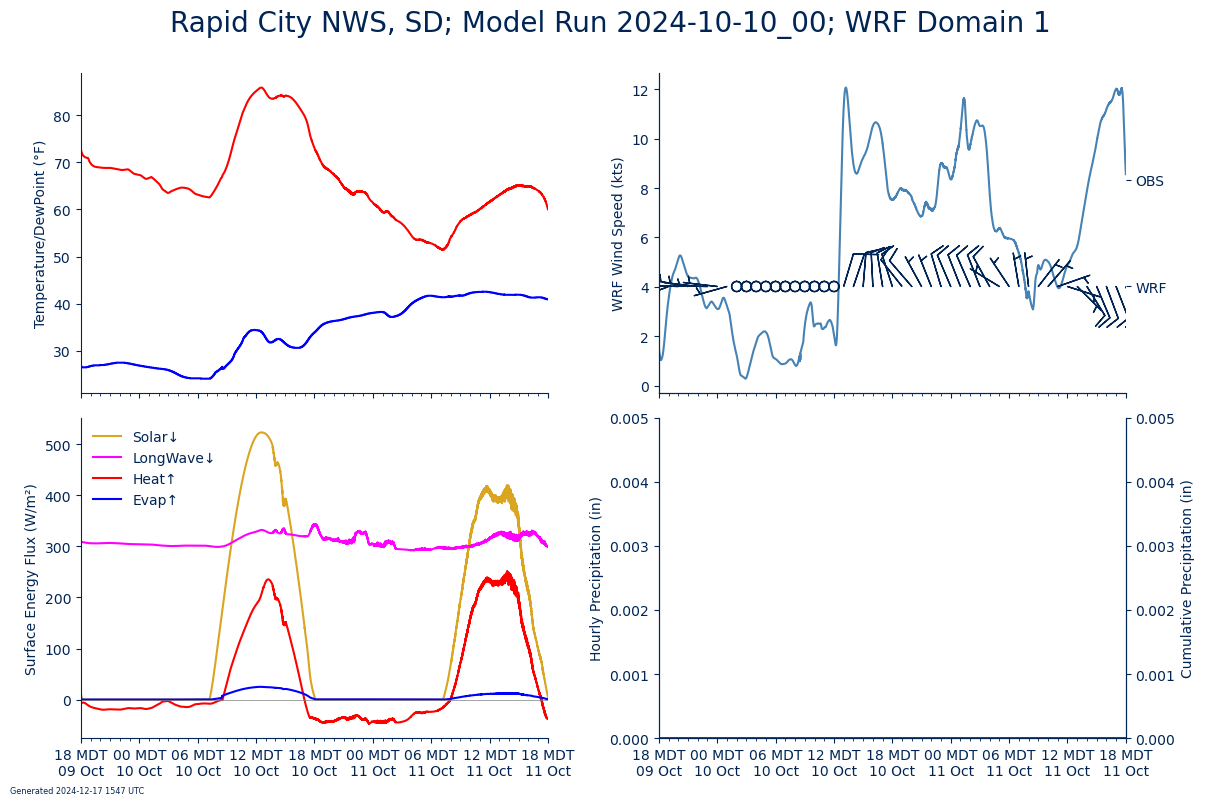

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KRCA.nc
distance between tslist and    wrf  1.7339386800389782
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


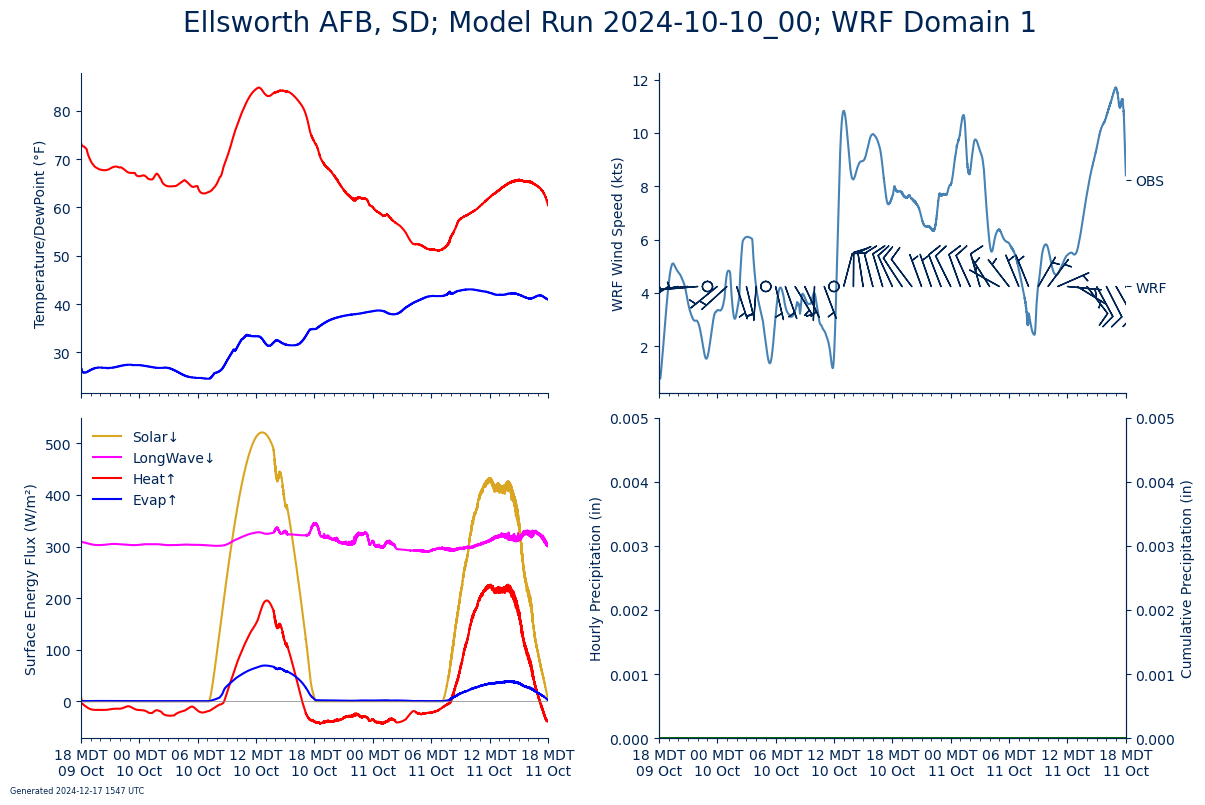

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KRAP.nc
distance between tslist and    wrf  3.656074956196296
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


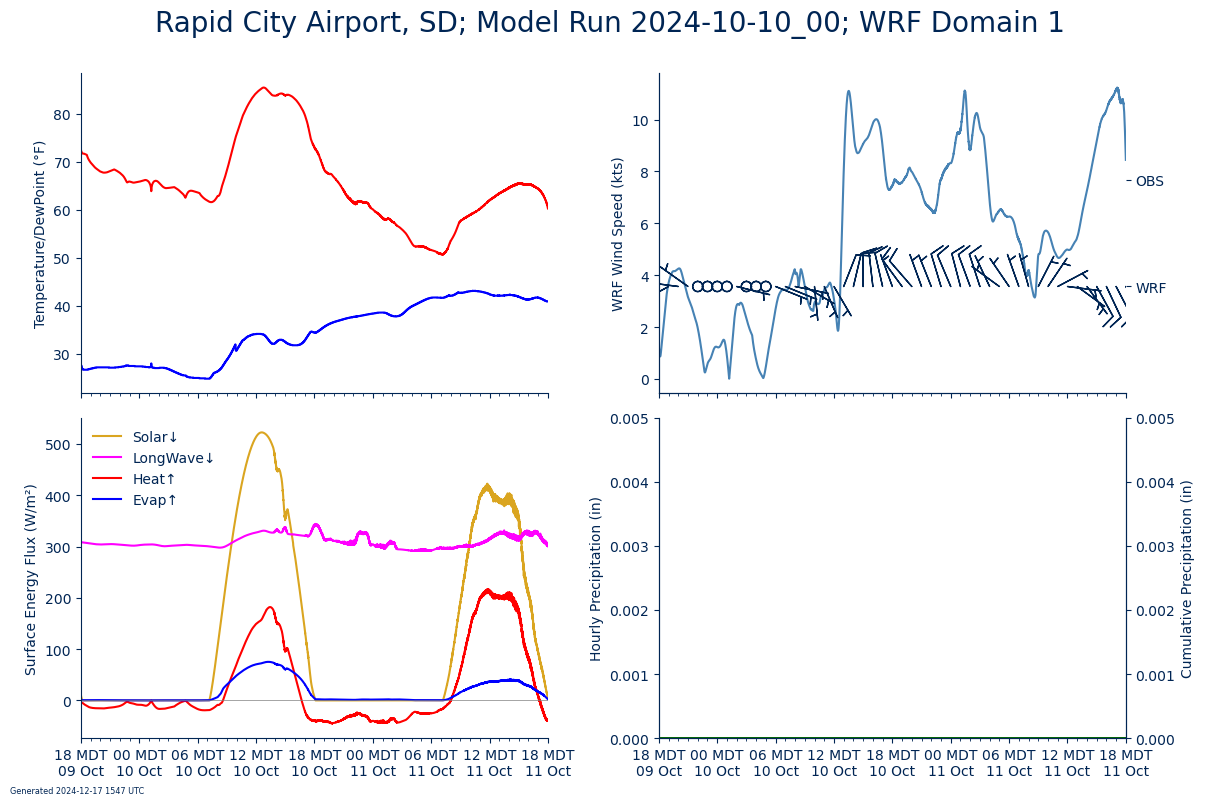

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KUDX.nc
distance between tslist and    wrf  2.796538930266744
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


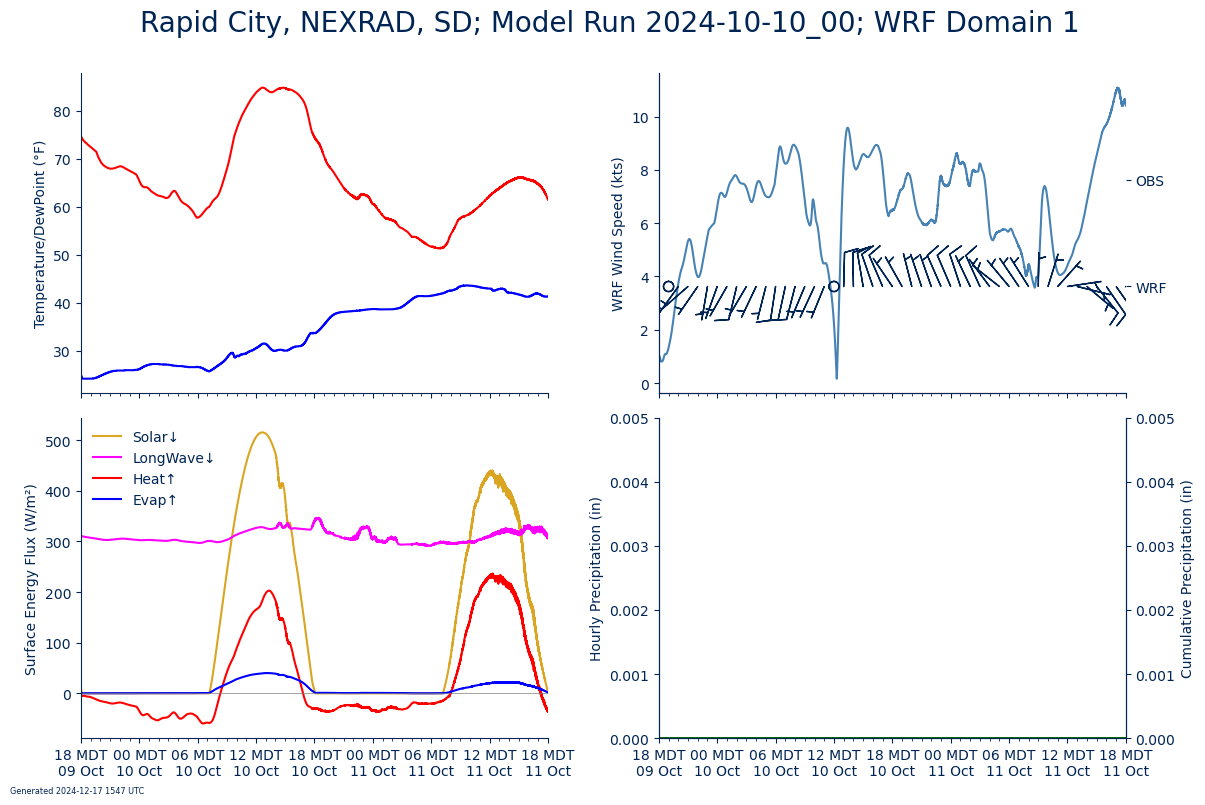

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KCUT.nc
distance between tslist and    wrf  2.8664327073184994
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


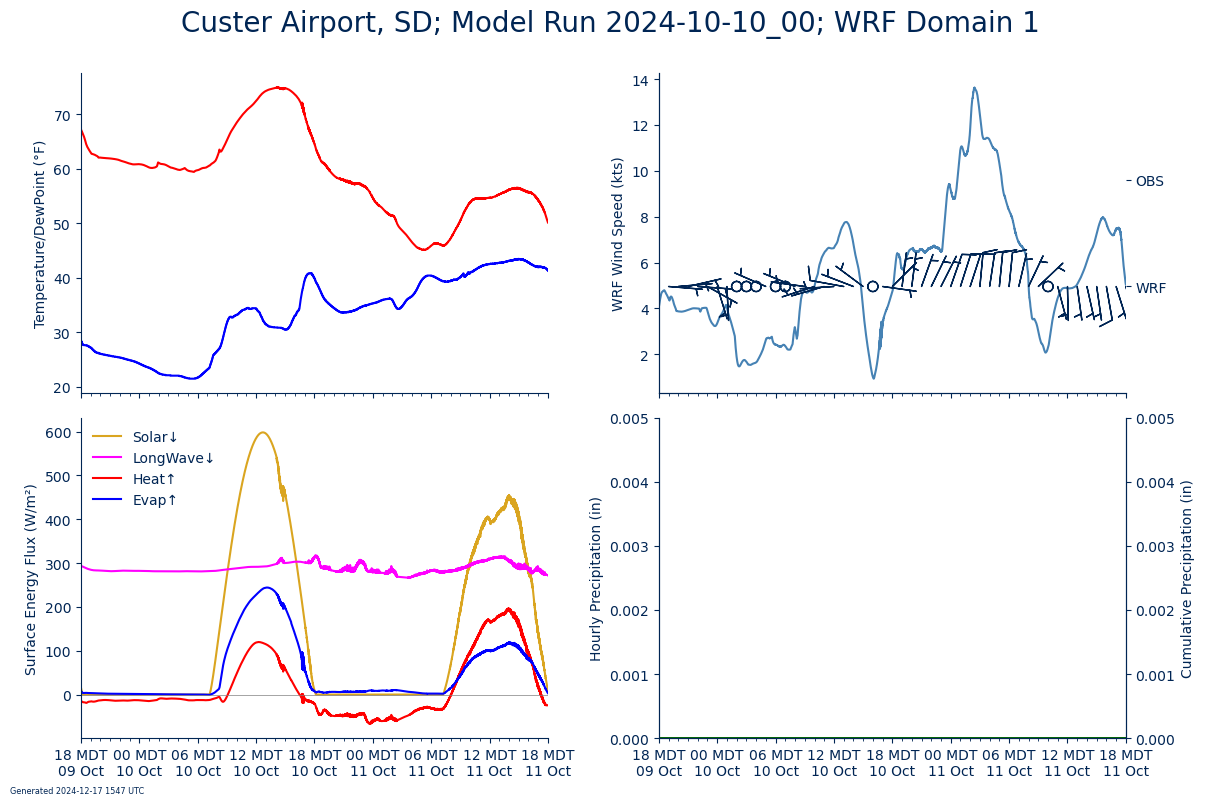

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KSPF.nc
distance between tslist and    wrf  2.2164443281446573
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


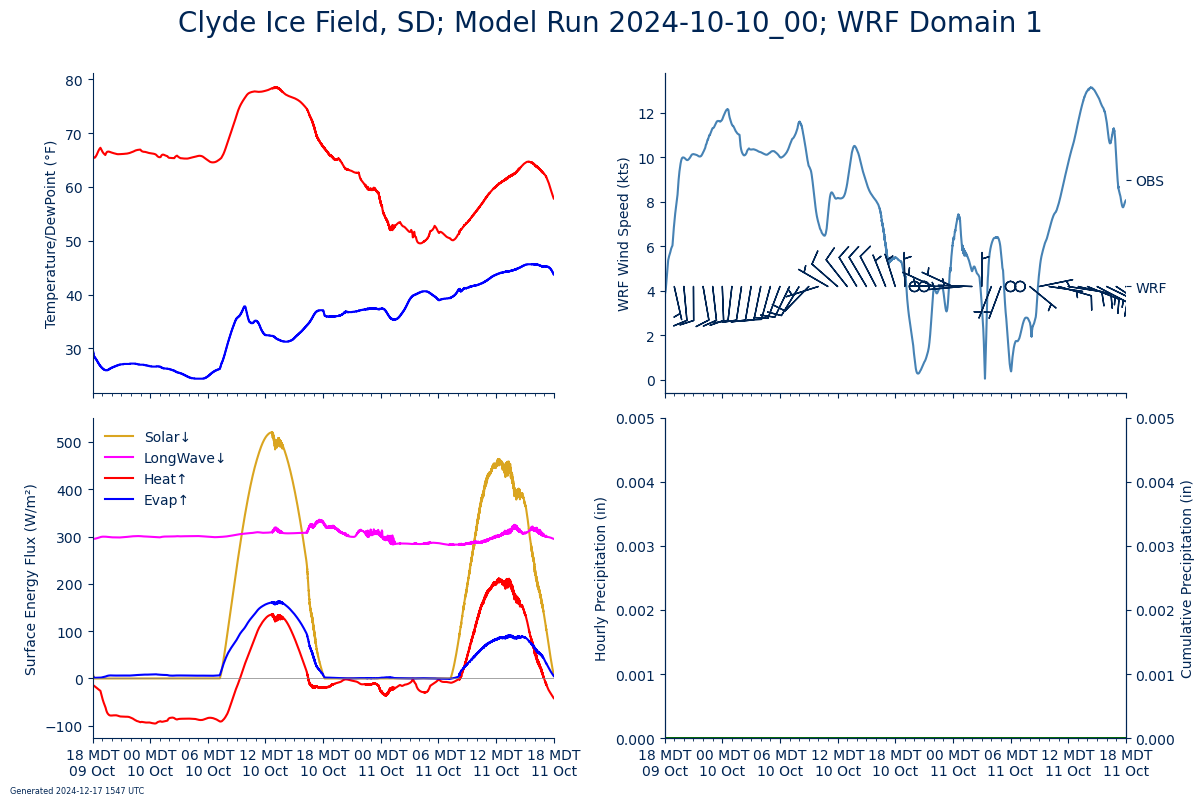

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KEFC.nc
distance between tslist and    wrf  3.682985375489354
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


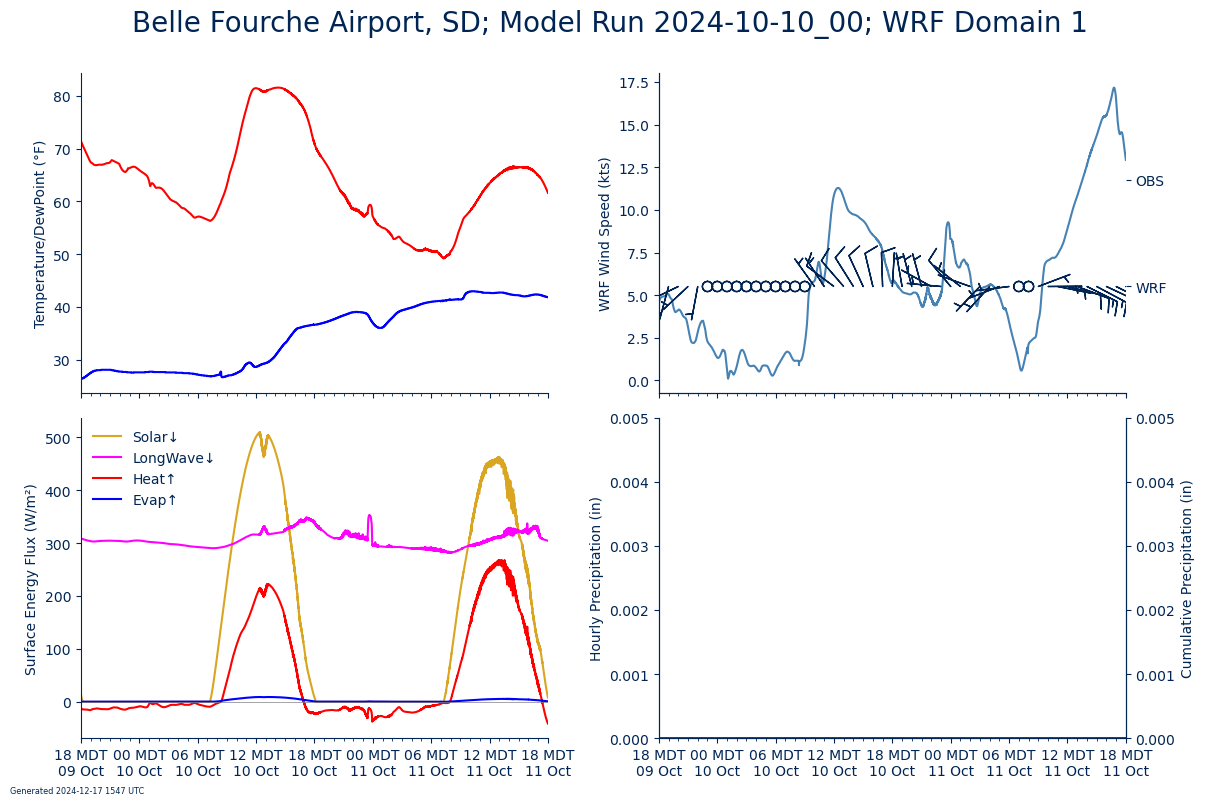

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KW43.nc
distance between tslist and    wrf  3.9157394984282754
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


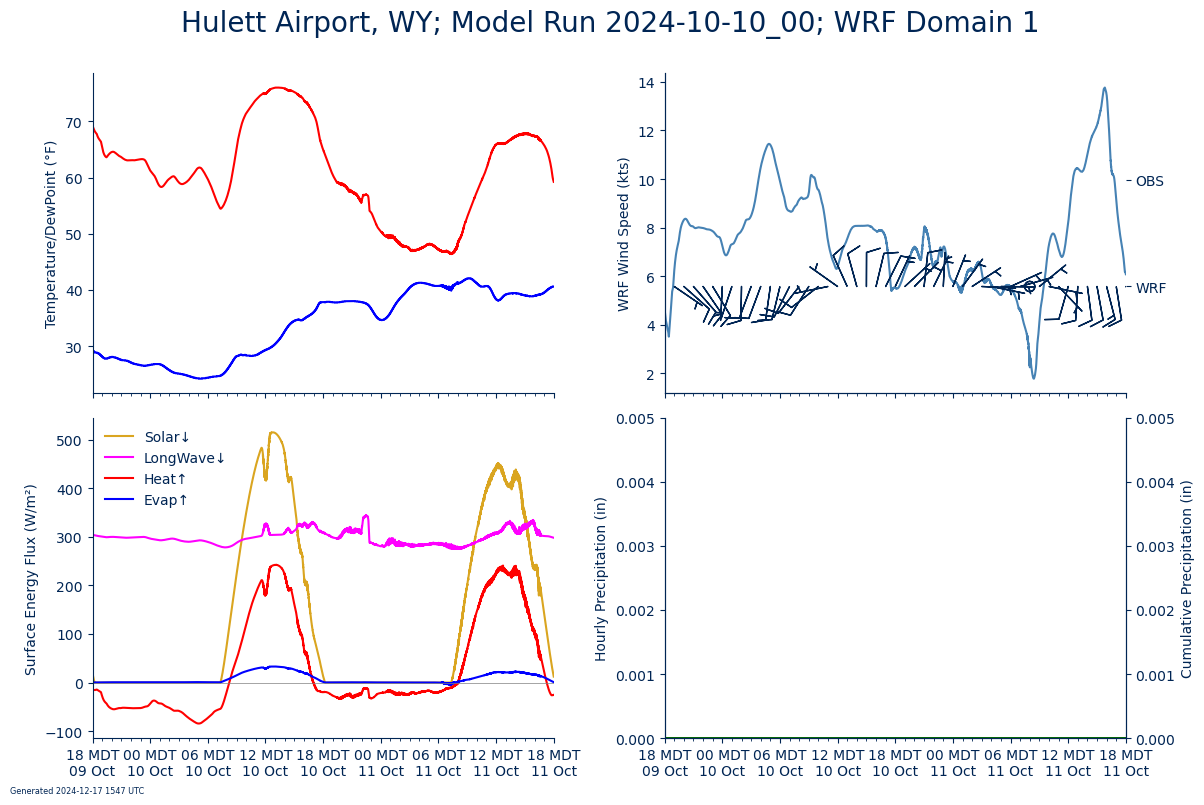

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KPHP.nc
distance between tslist and    wrf  2.092769363775105
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


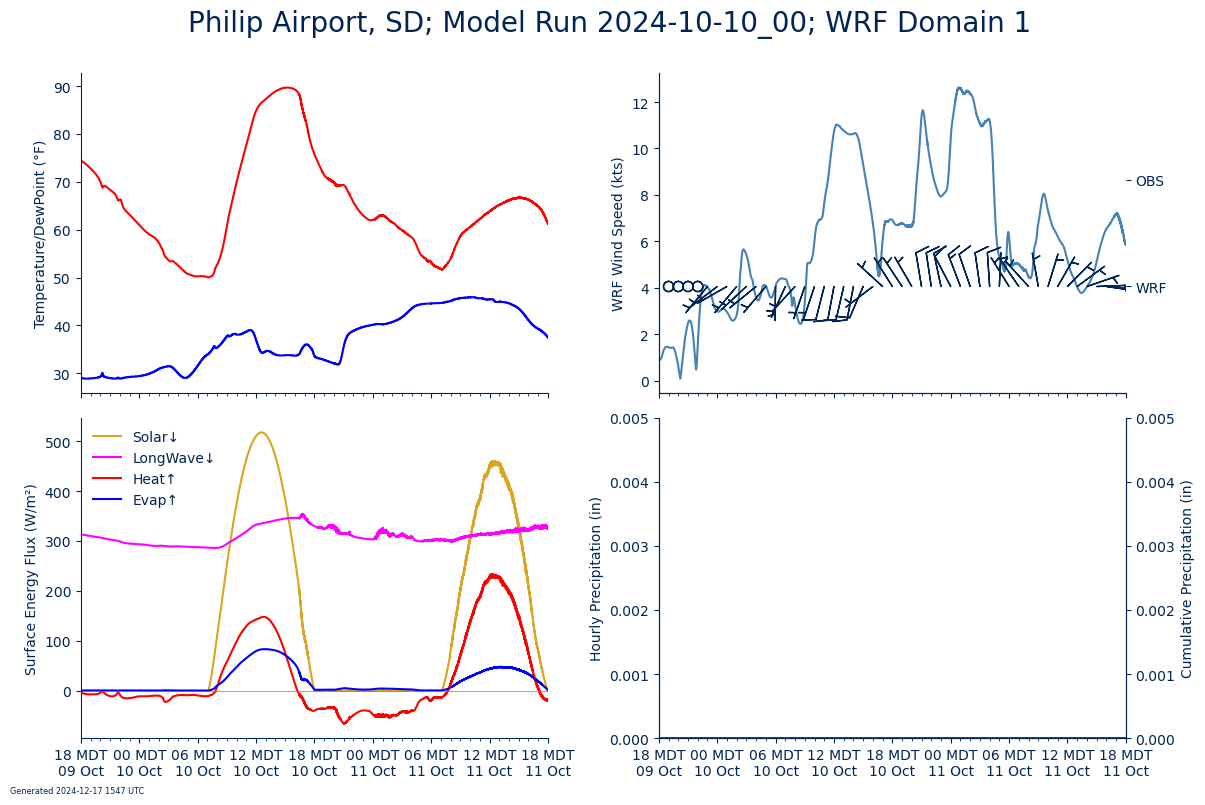

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KIEN.nc
distance between tslist and    wrf  1.261387754002912
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


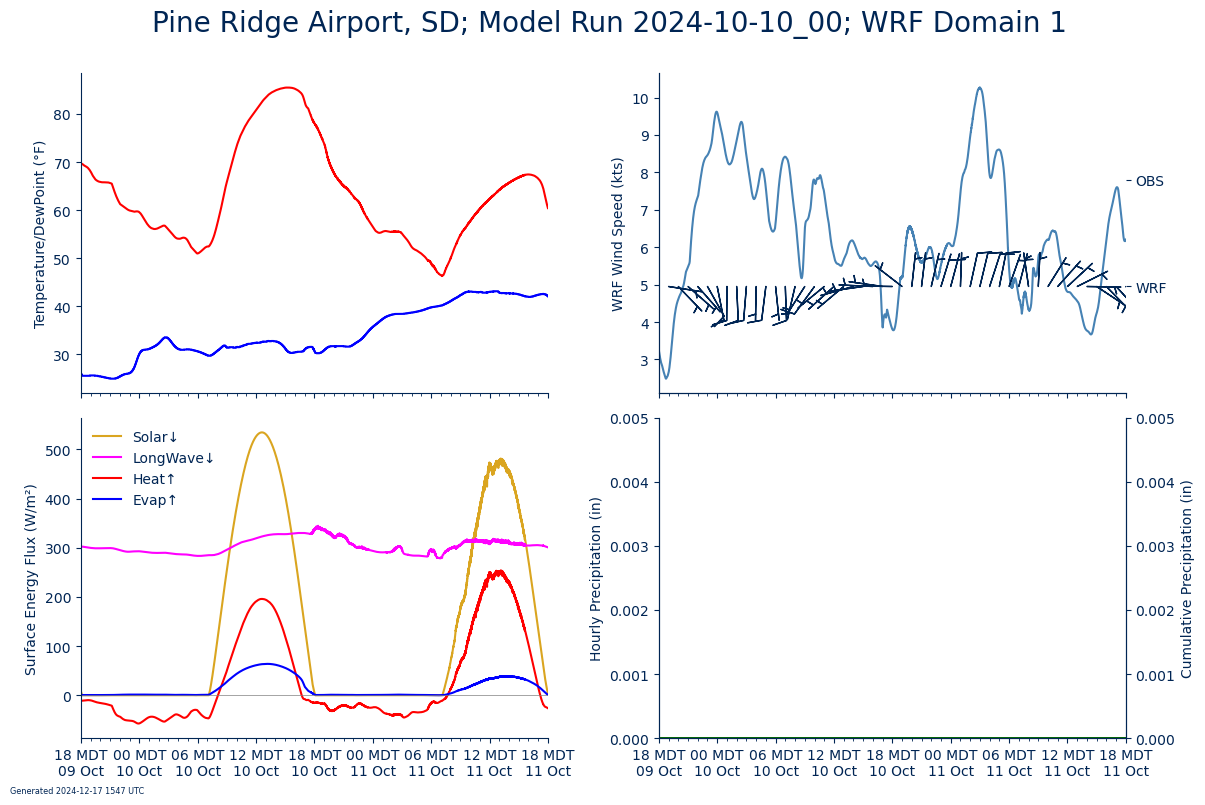

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KCDR.nc
distance between tslist and    wrf  2.0843208621668685
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


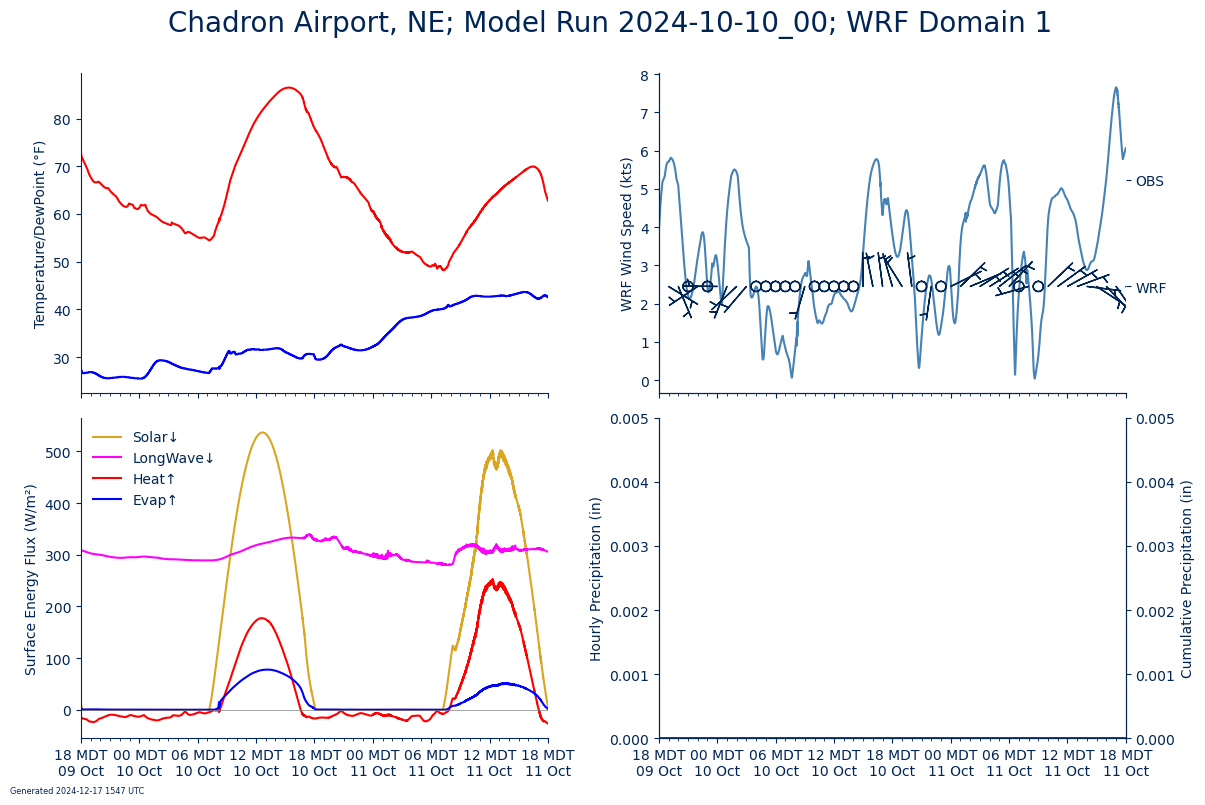

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_K4MC.nc
distance between tslist and    wrf  4.683801616329673
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


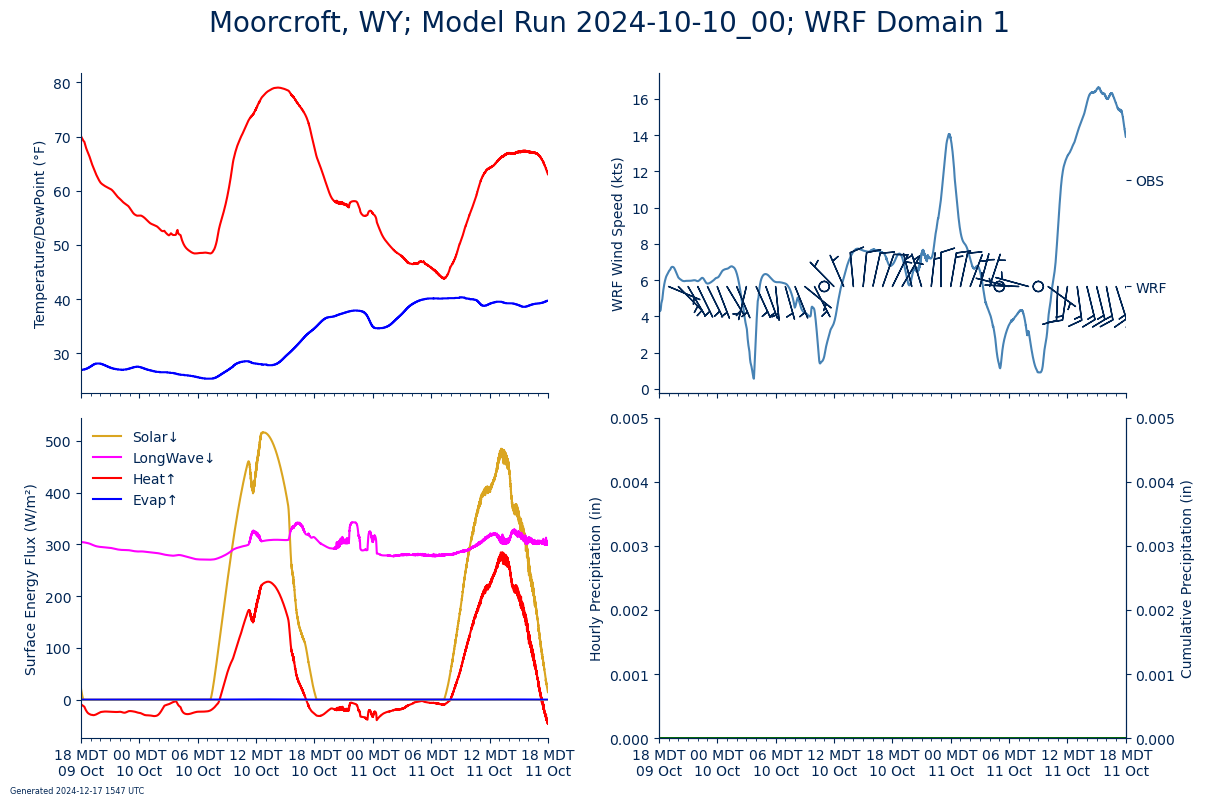

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KD07.nc
distance between tslist and    wrf  3.4736104820300757
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


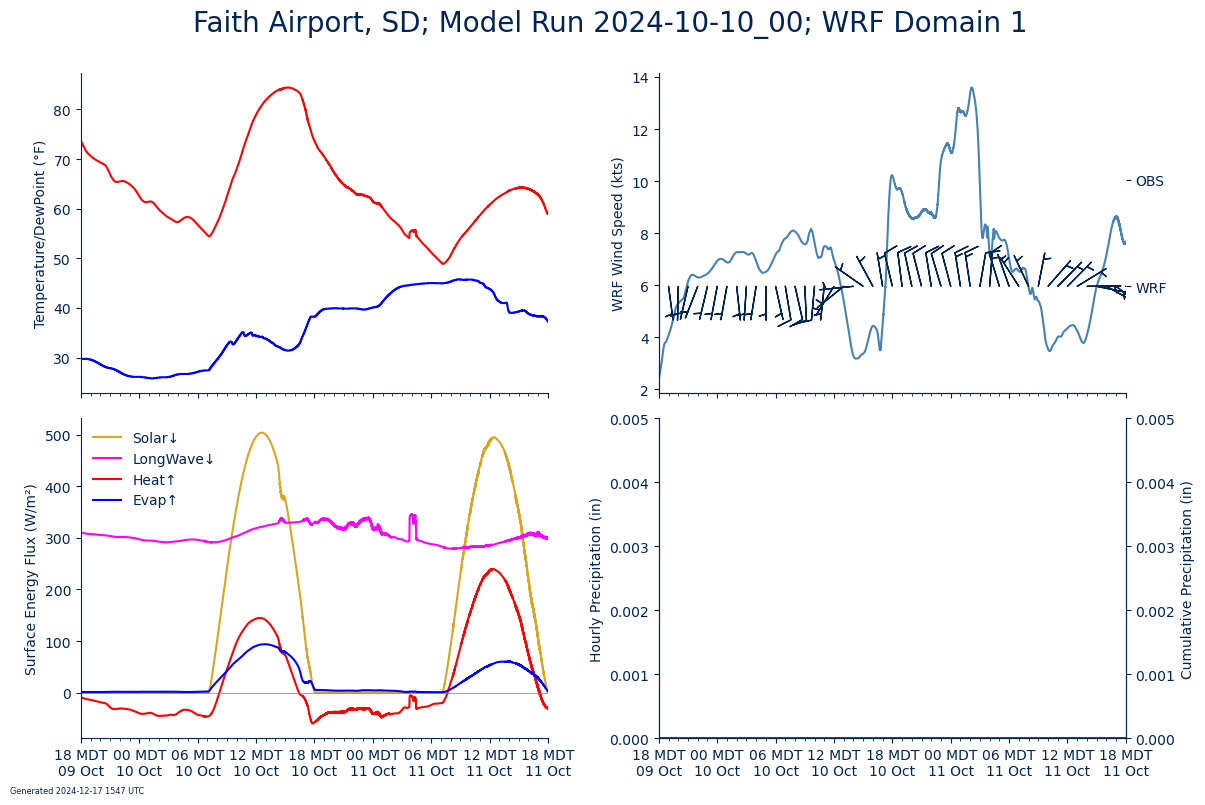

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KGRN.nc
distance between tslist and    wrf  4.556584352150839
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


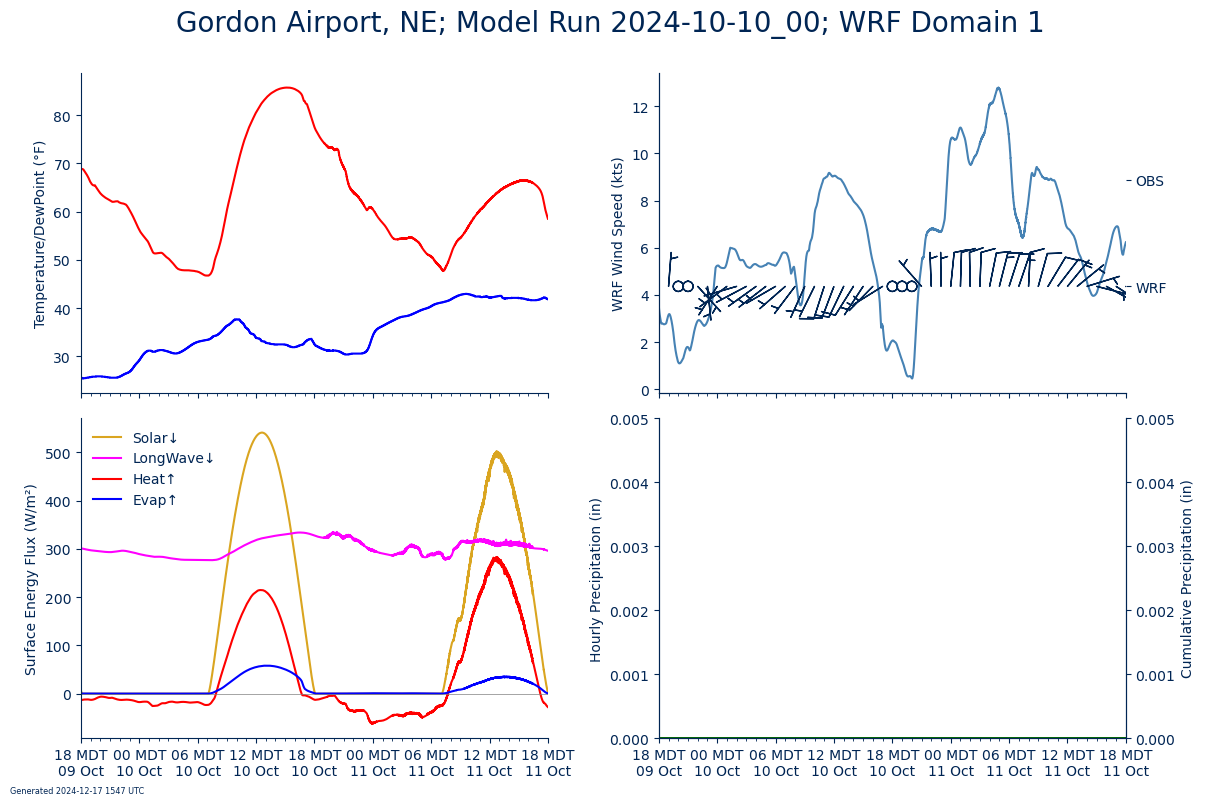

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_K2WX.nc
distance between tslist and    wrf  1.1764670823789947
Total precip:  0.017387401574803157  in
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


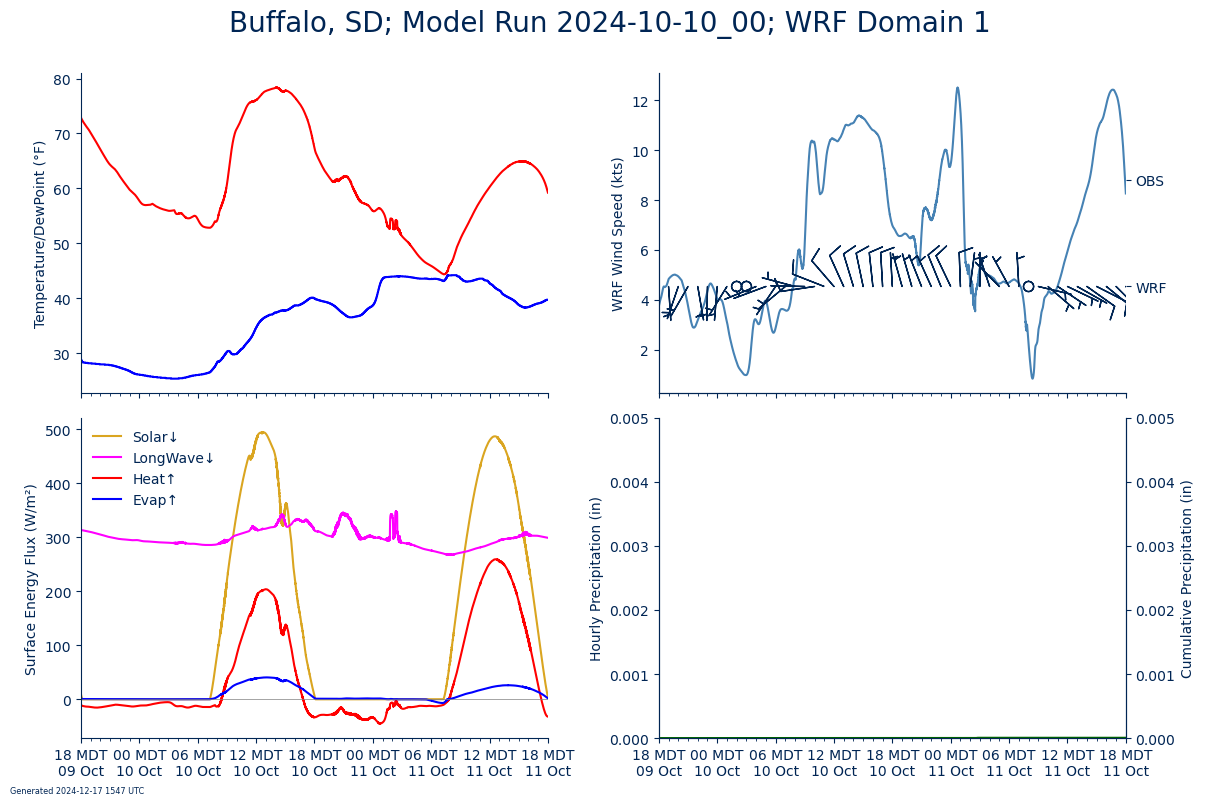

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KGCC.nc
distance between tslist and    wrf  3.5212983248035608
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


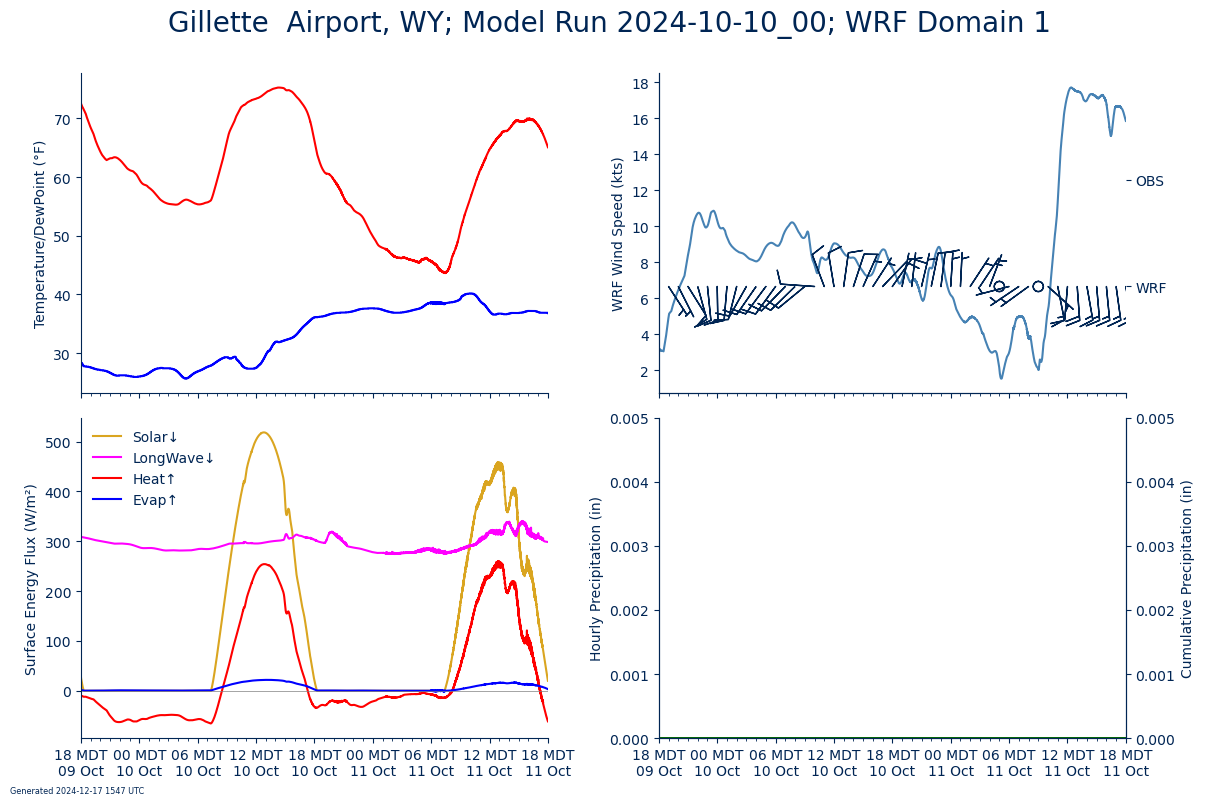

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KHEI.nc
distance between tslist and    wrf  1.8252985048019206
Total precip:  1.695237007874016  in
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


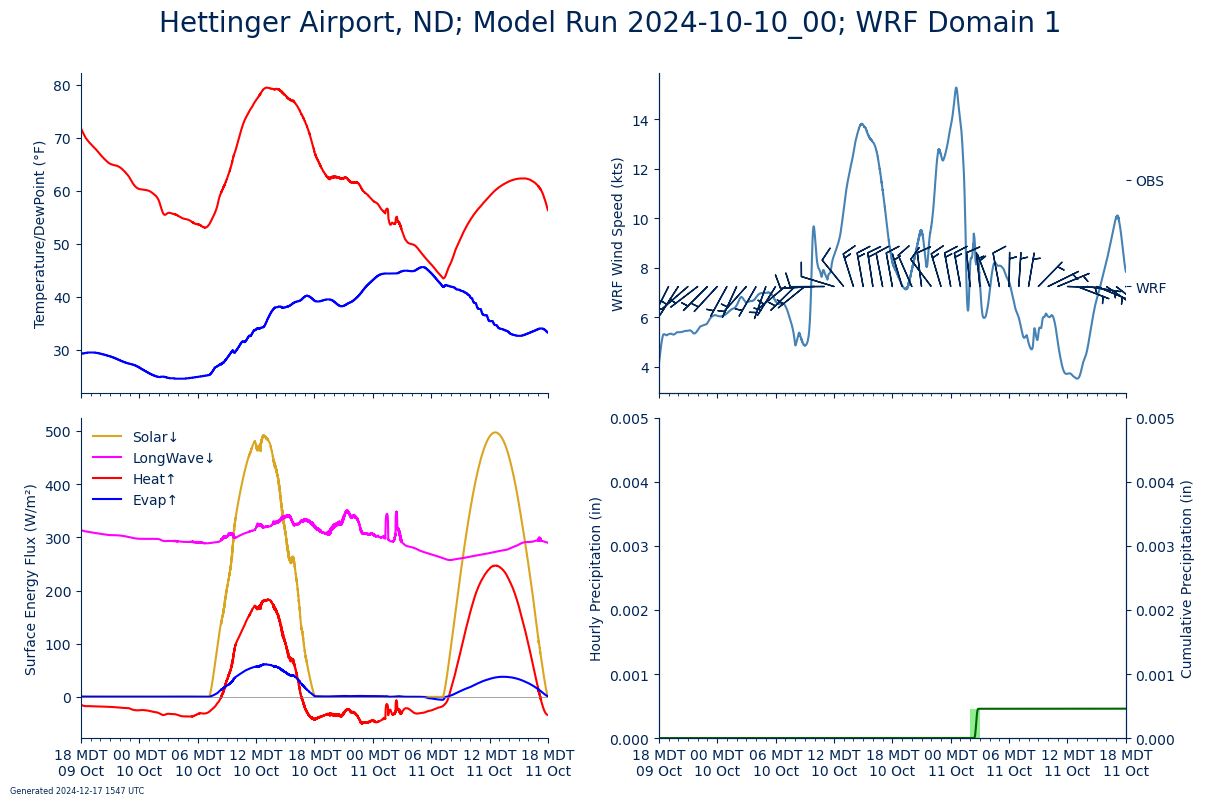

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KY22.nc
distance between tslist and    wrf  0.7821985495285048
Total precip:  0.271728346456693  in
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


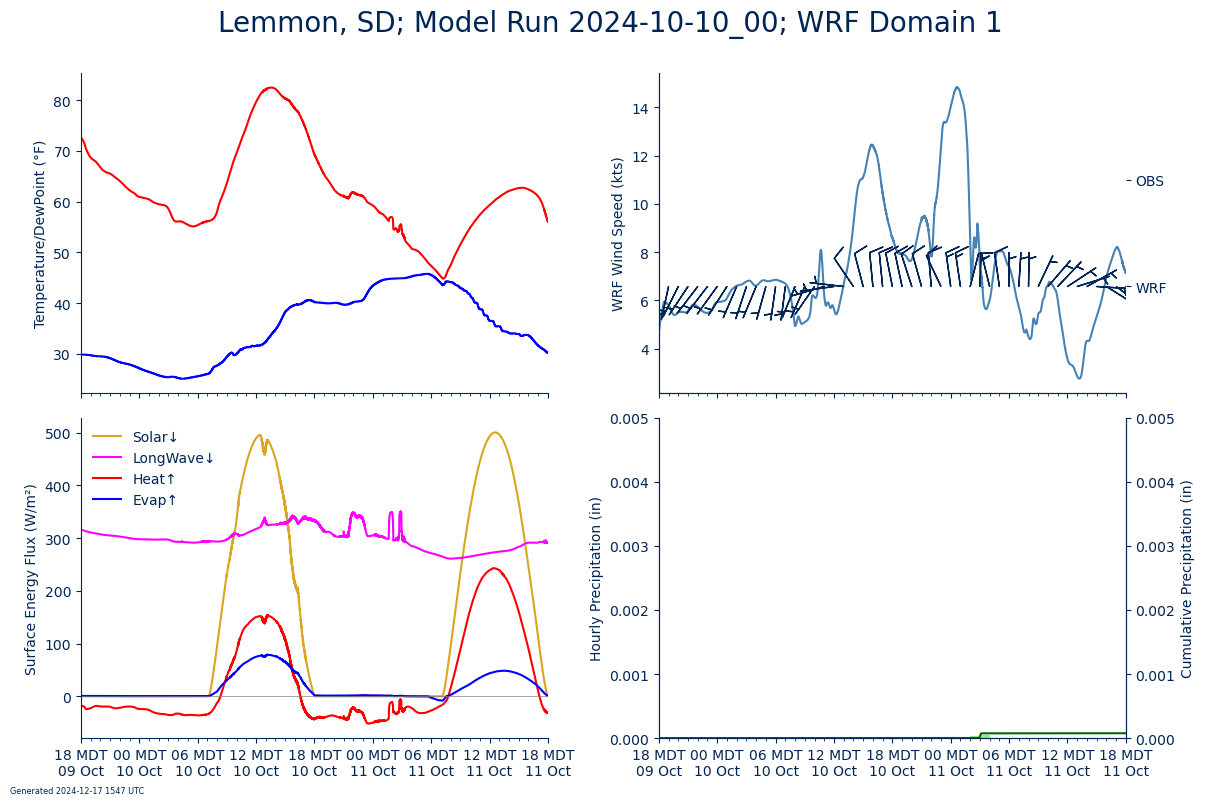

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KLEM.nc
distance between tslist and    wrf  4.229922757855552
Total precip:  0.28992362204724403  in
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


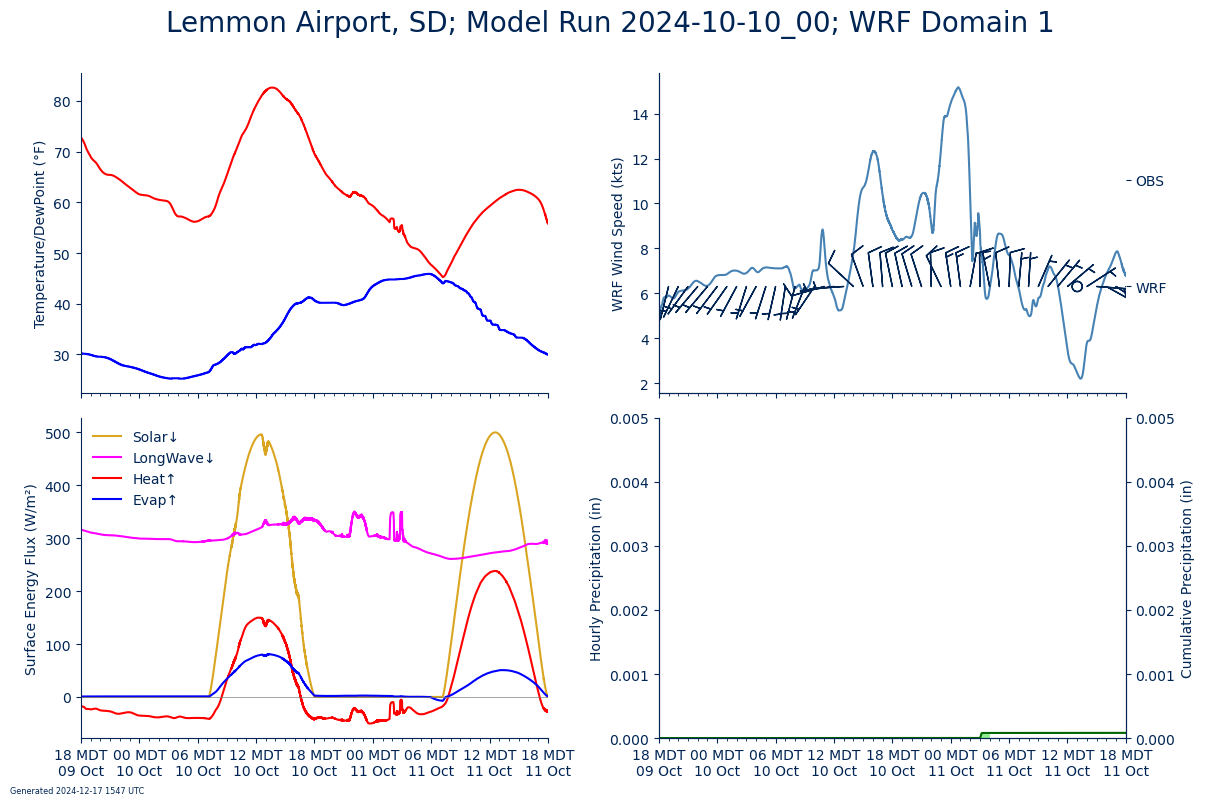

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KDGW.nc
distance between tslist and    wrf  3.045980873134766
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


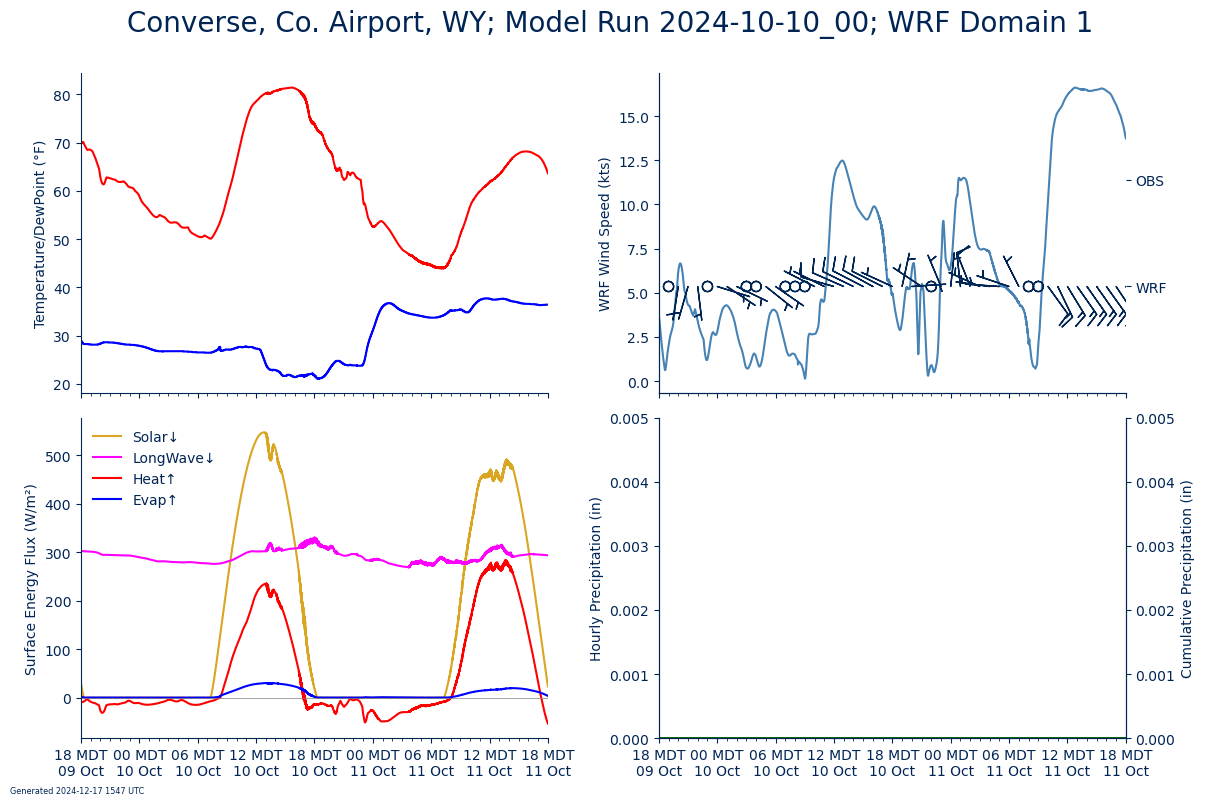

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KAIA.nc
distance between tslist and    wrf  4.223458242464319
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


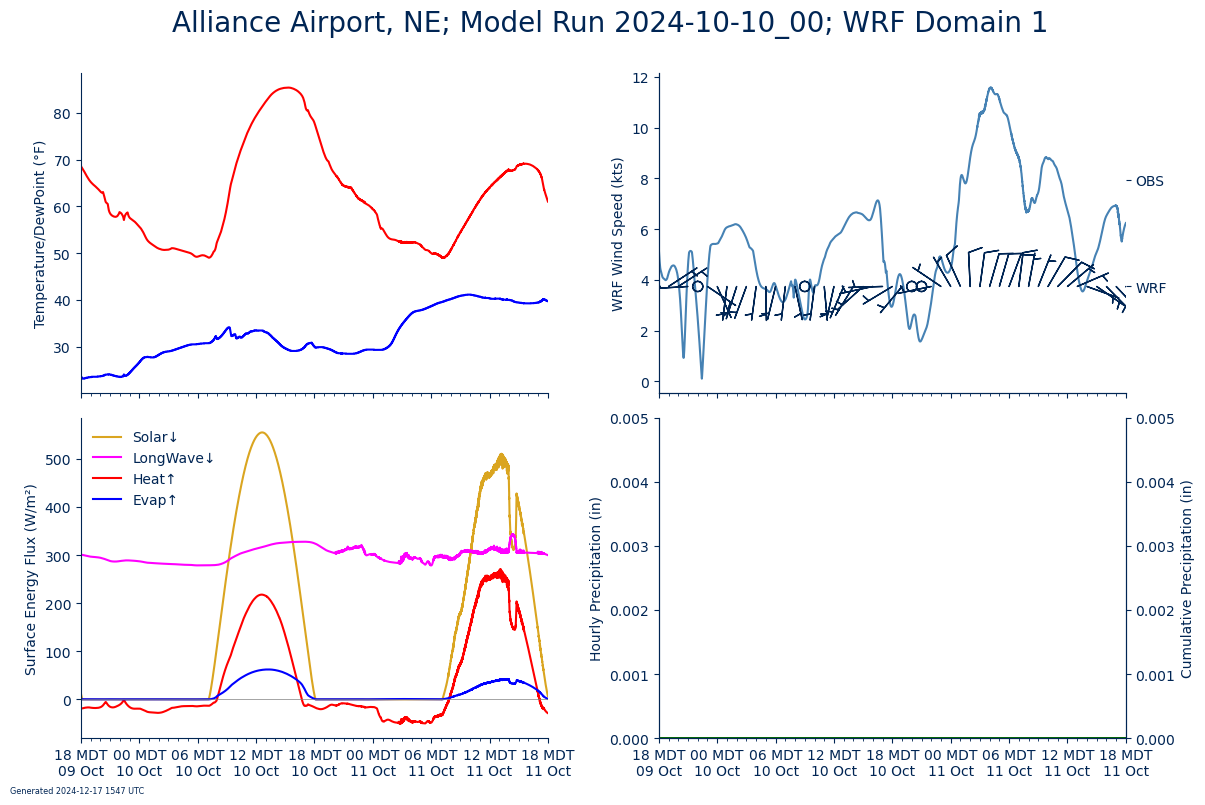

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_K4DG.nc
distance between tslist and    wrf  1.567270236187149
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


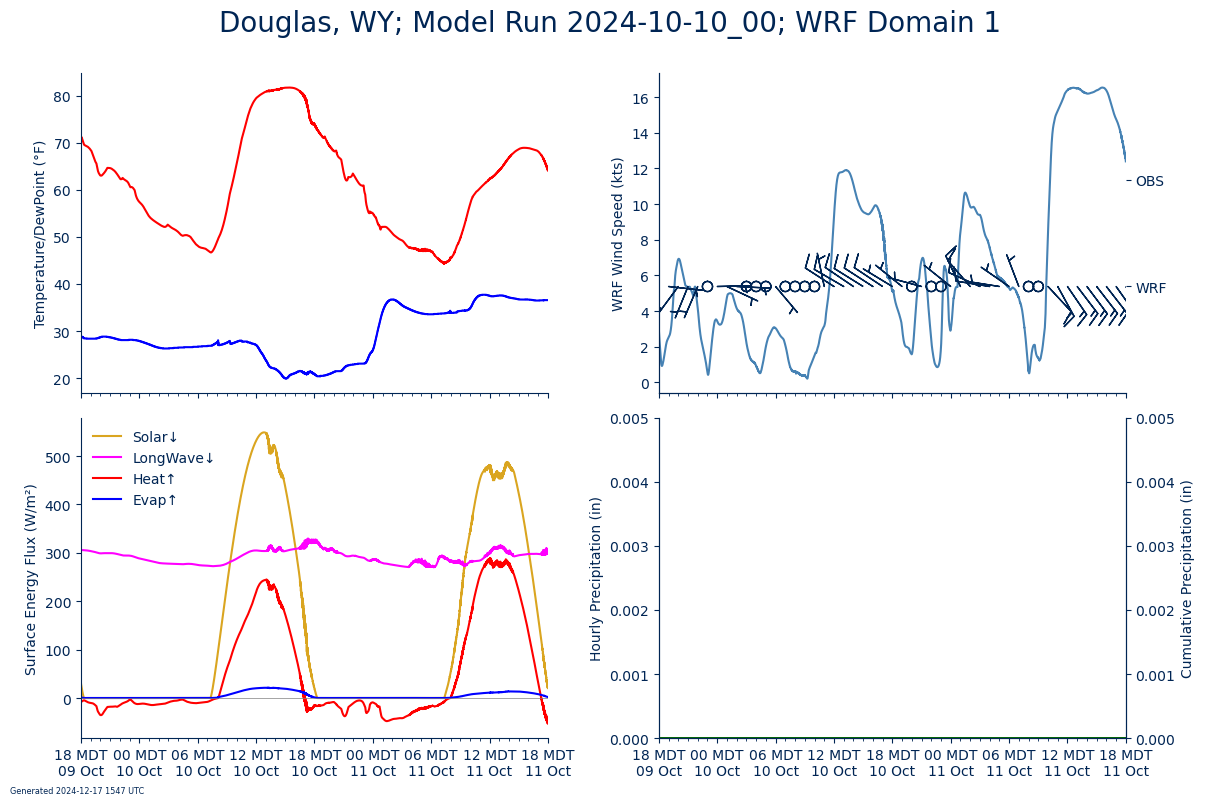

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KBWW.nc
distance between tslist and    wrf  2.6330378517003856
Total precip:  19.670597244094484  in
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


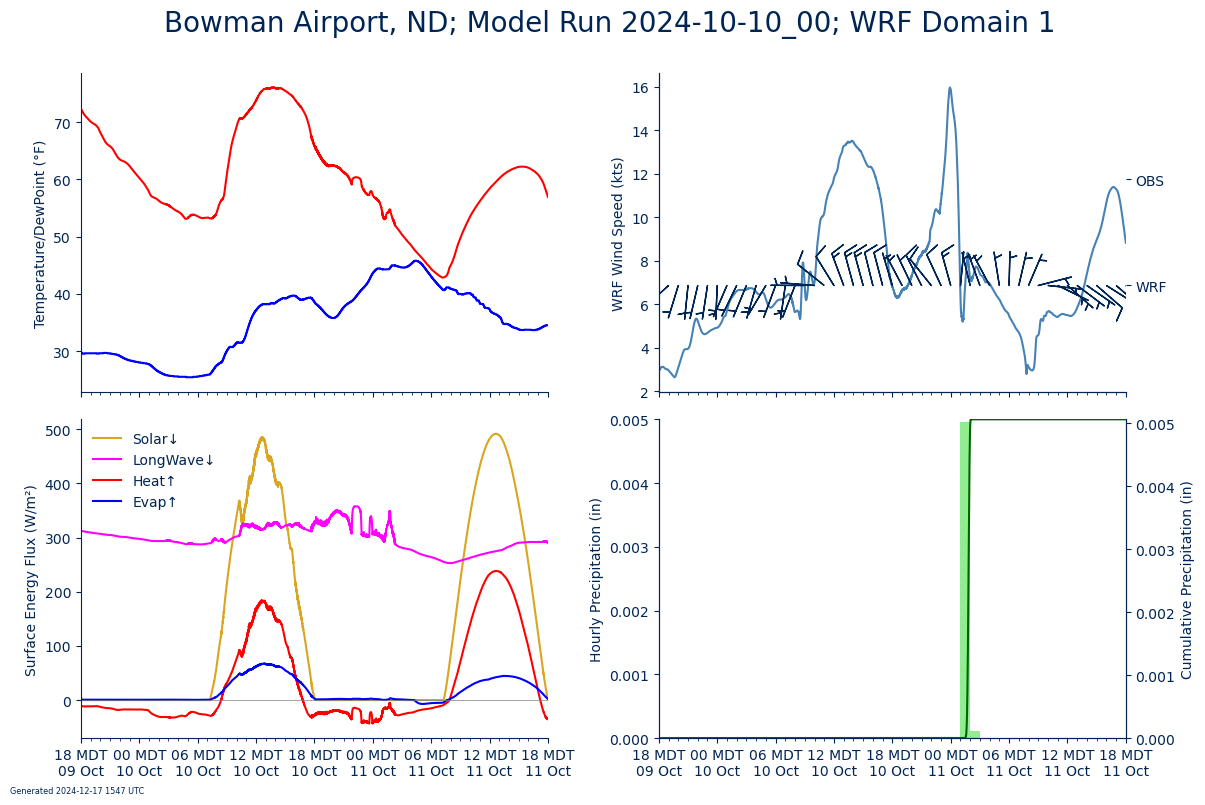

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KSIB.nc
distance between tslist and    wrf  1.9152799122335473
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


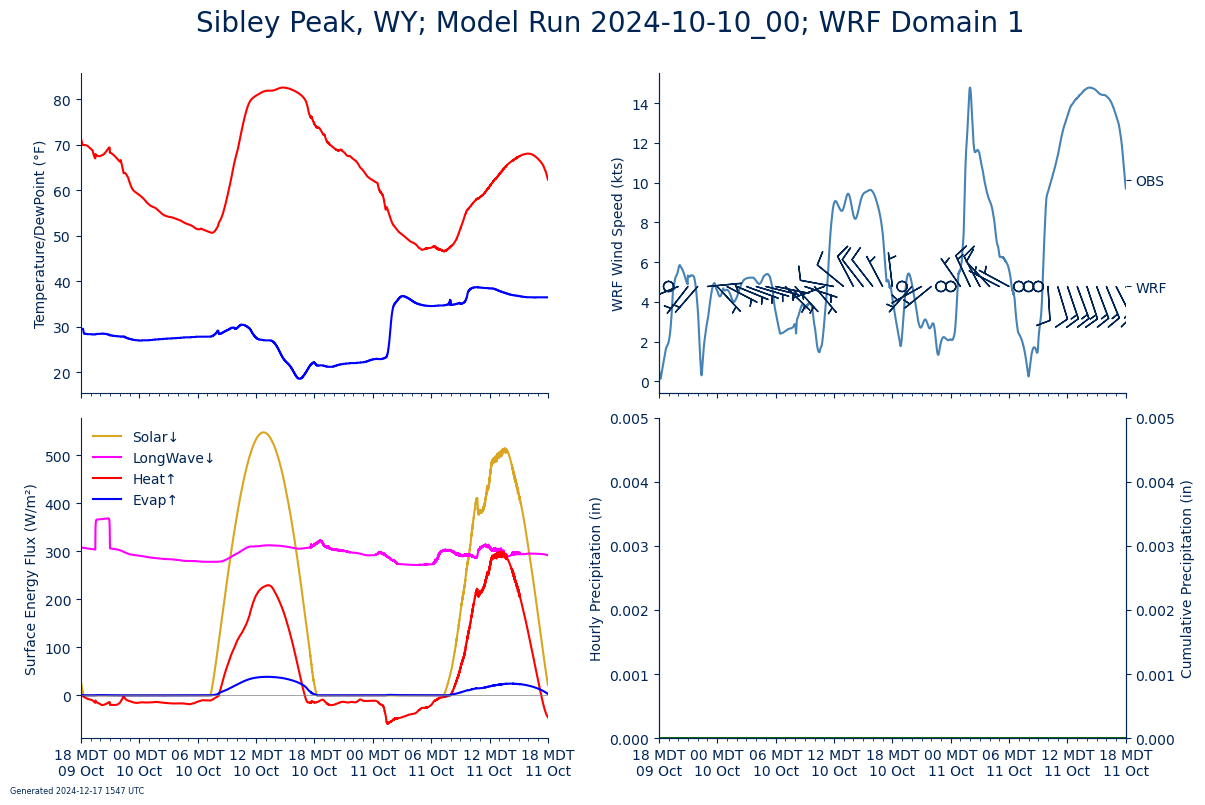

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KPIR.nc
distance between tslist and    wrf  3.0115110182650073
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


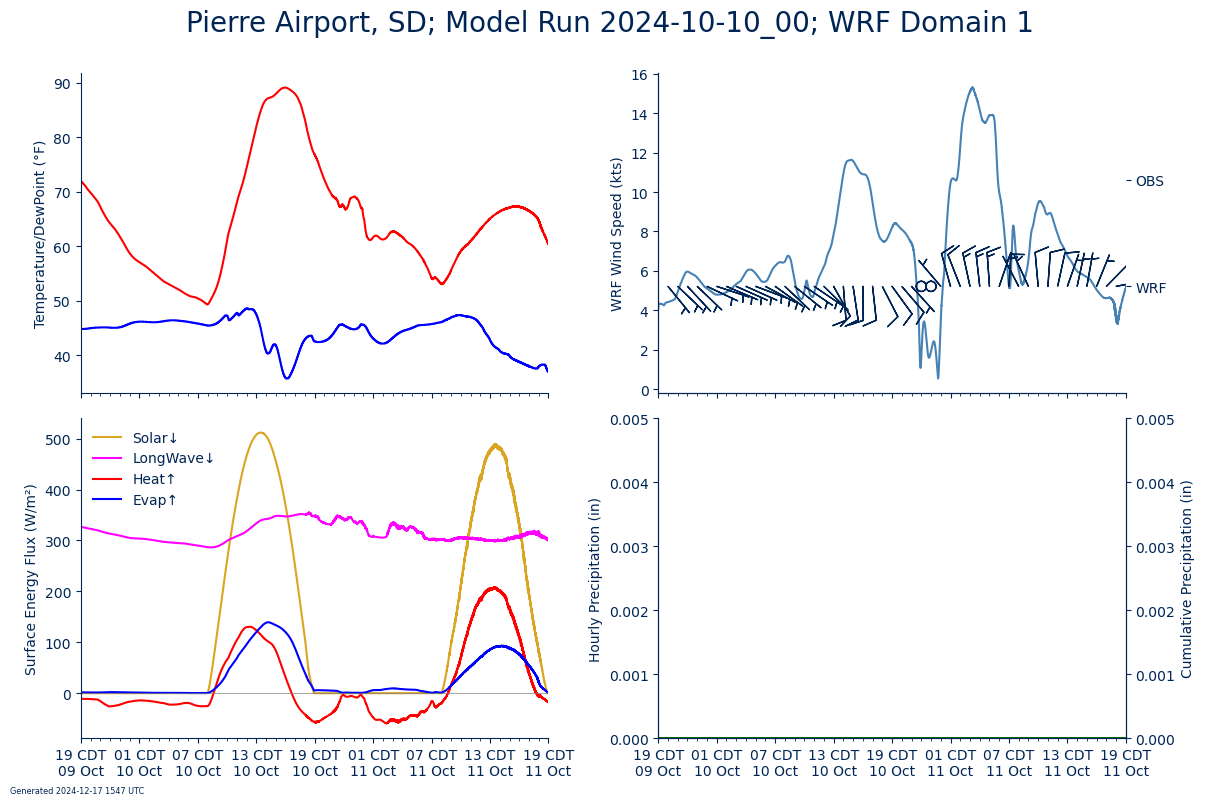

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KTOR.nc
distance between tslist and    wrf  3.1827689534592194
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


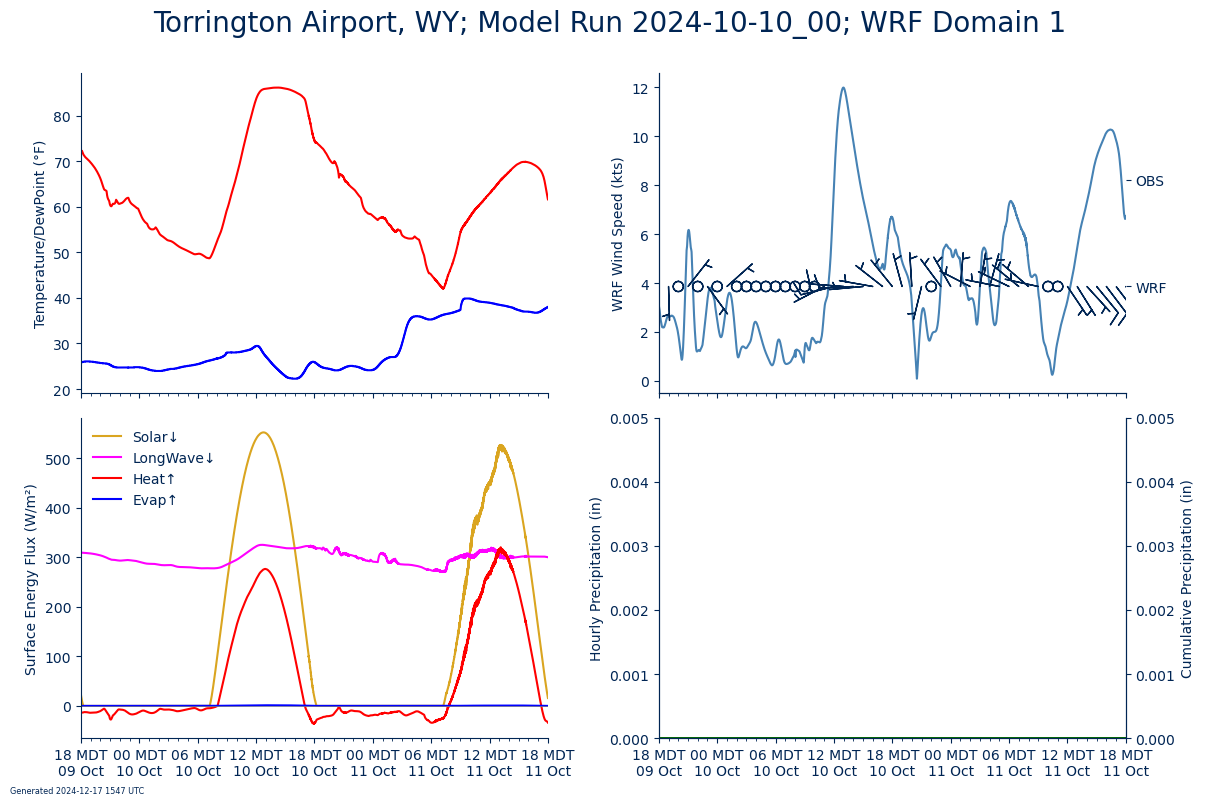

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KMIS.nc
distance between tslist and    wrf  5.112314455843038
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


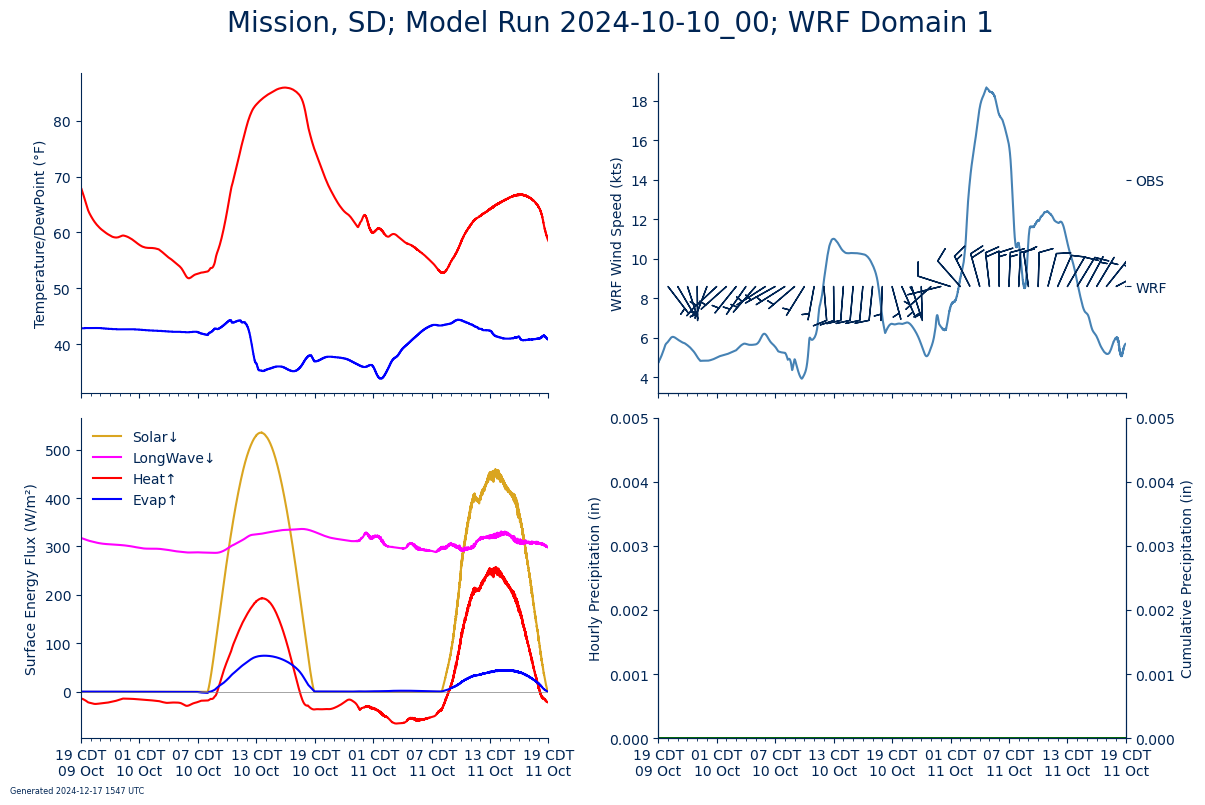

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KBFF.nc
distance between tslist and    wrf  2.253748255228174
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


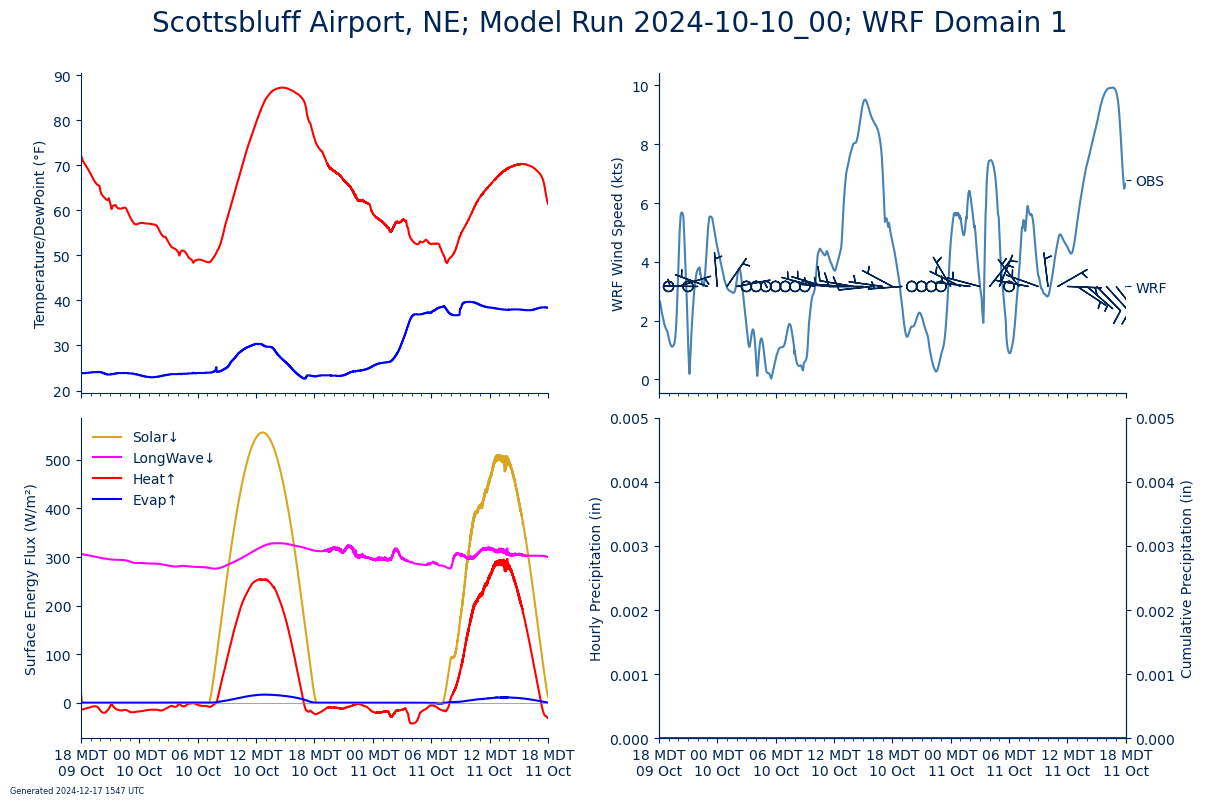

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KVTN.nc
distance between tslist and    wrf  3.6503032271436373
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


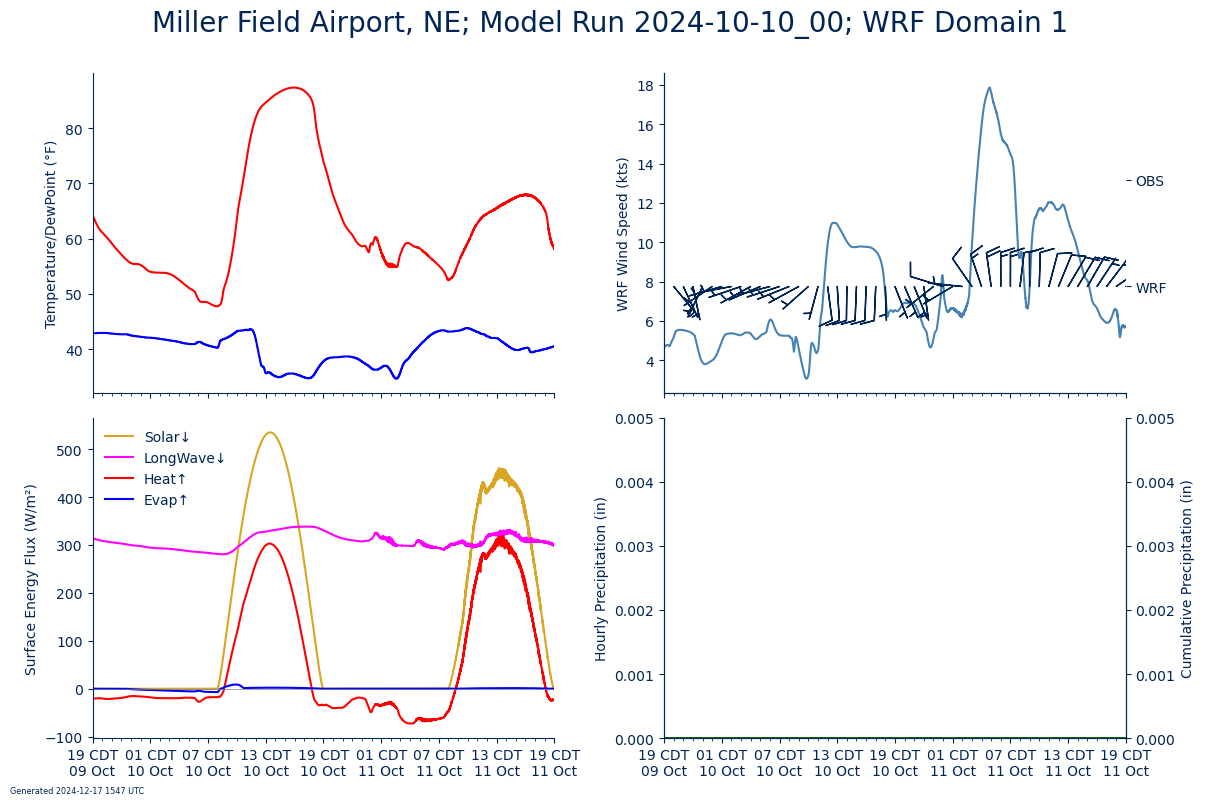

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KCYS.nc
distance between tslist and    wrf  2.9767145314759555
Total precip:  0.008758267716535434  in
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


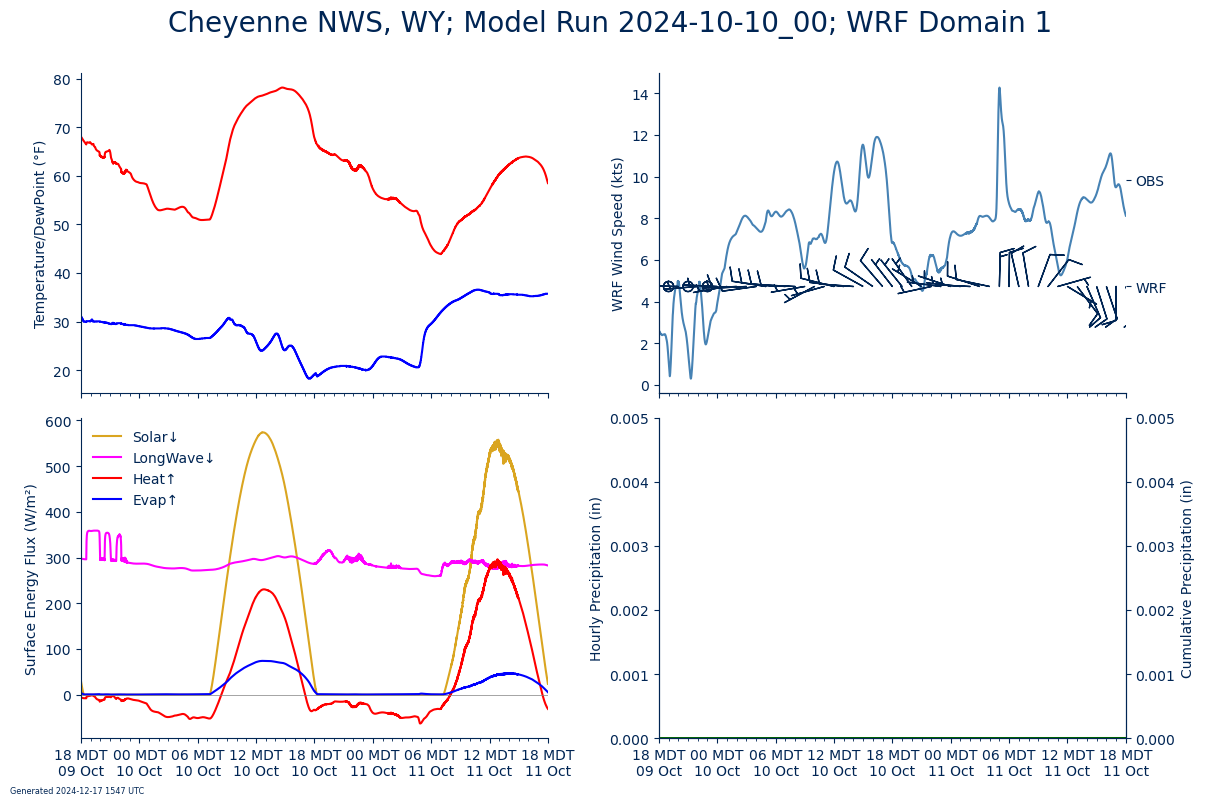

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KBIS.nc
distance between tslist and    wrf  3.059402980008804
Total precip:  0.31293346456692916  in
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


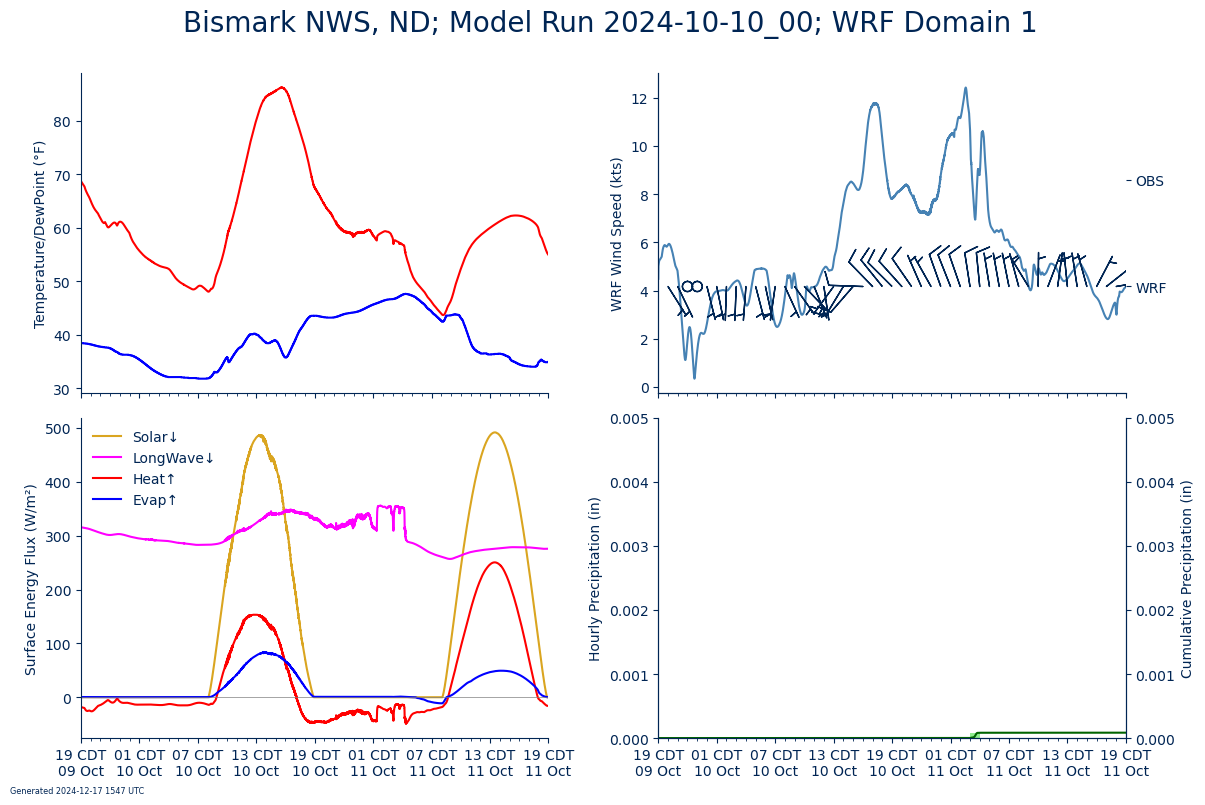

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KLBF.nc
distance between tslist and    wrf  2.4219831806428904
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


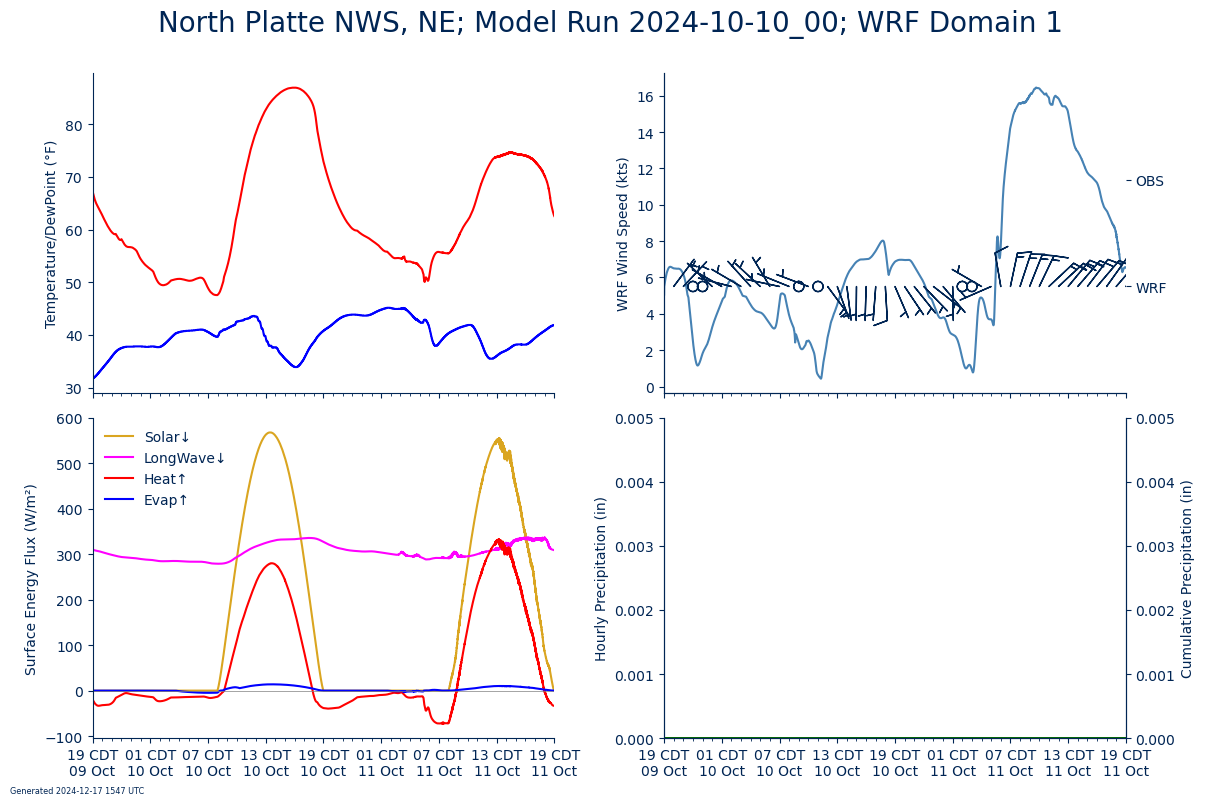

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KABR.nc
distance between tslist and    wrf  4.503582781243544
Total precip:  0.8418692913385827  in
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


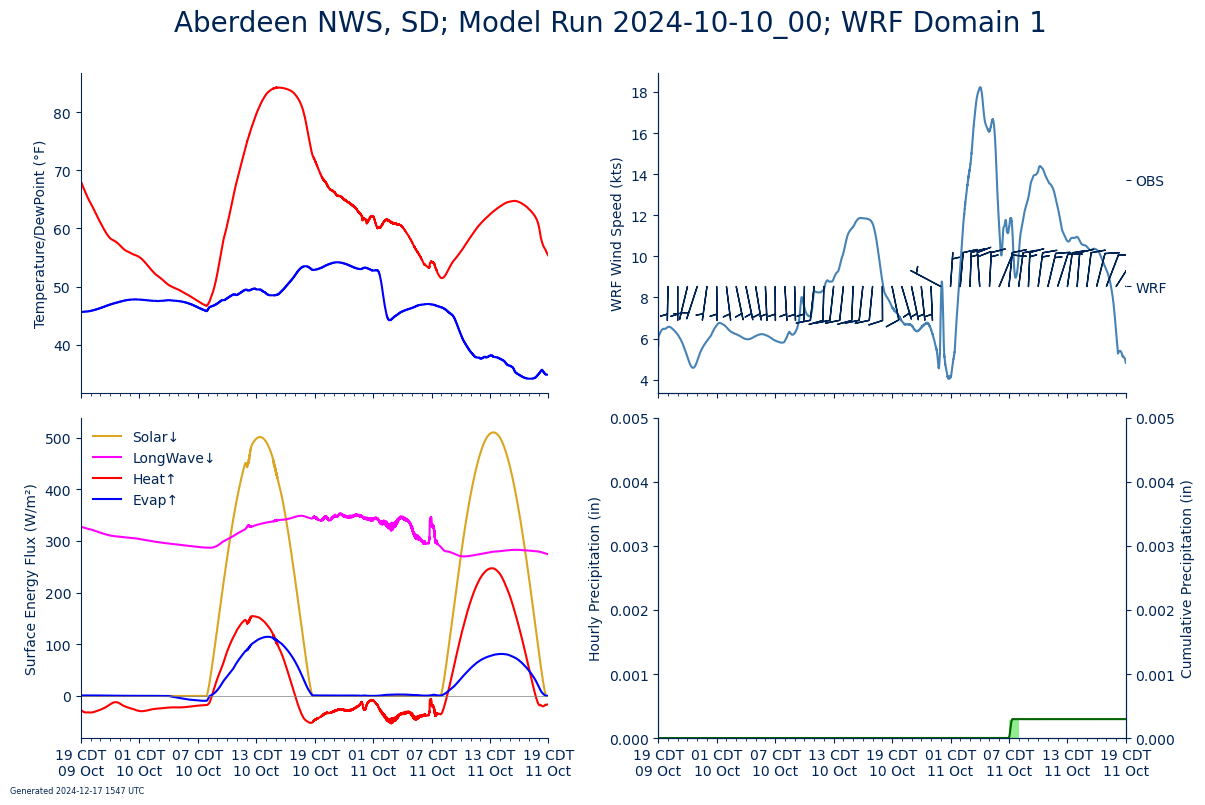

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KRIW.nc
distance between tslist and    wrf  5.855445658835231
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


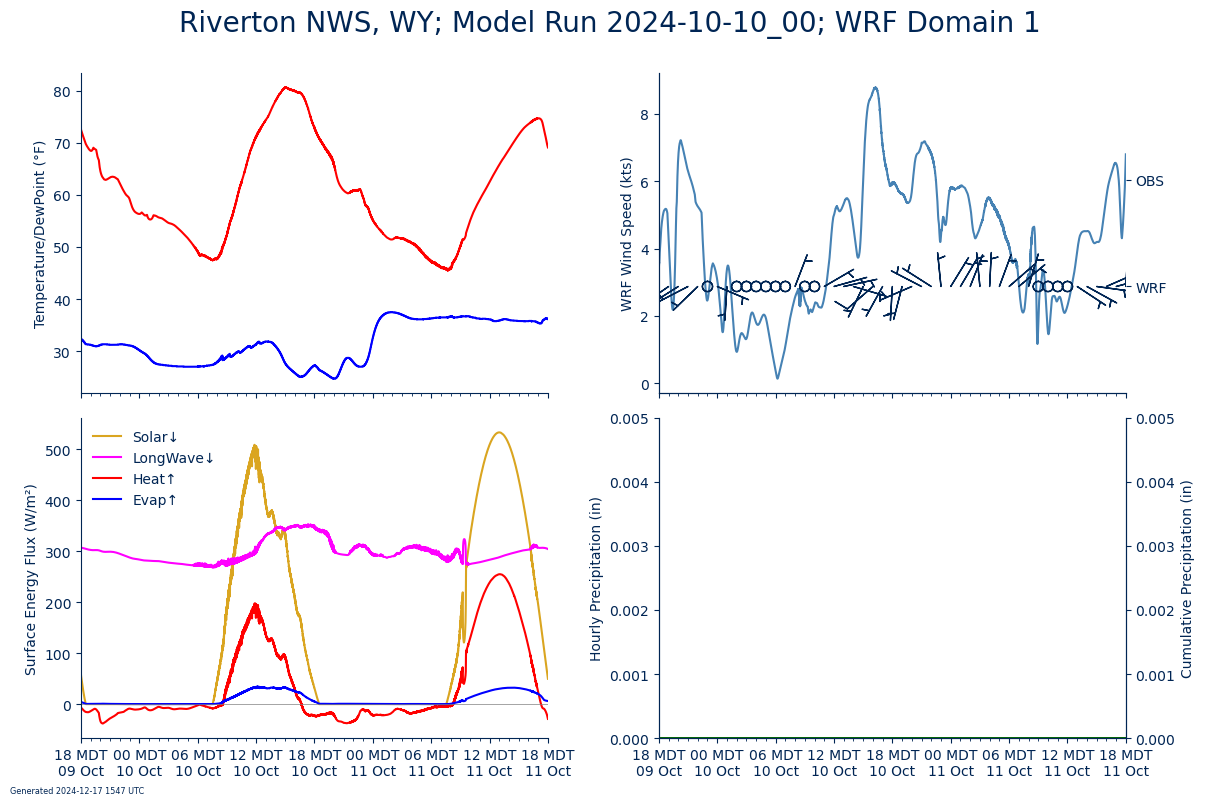

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KBYZ.nc
distance between tslist and    wrf  3.7840309771959744
Total precip:  2.203881496062992  in
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


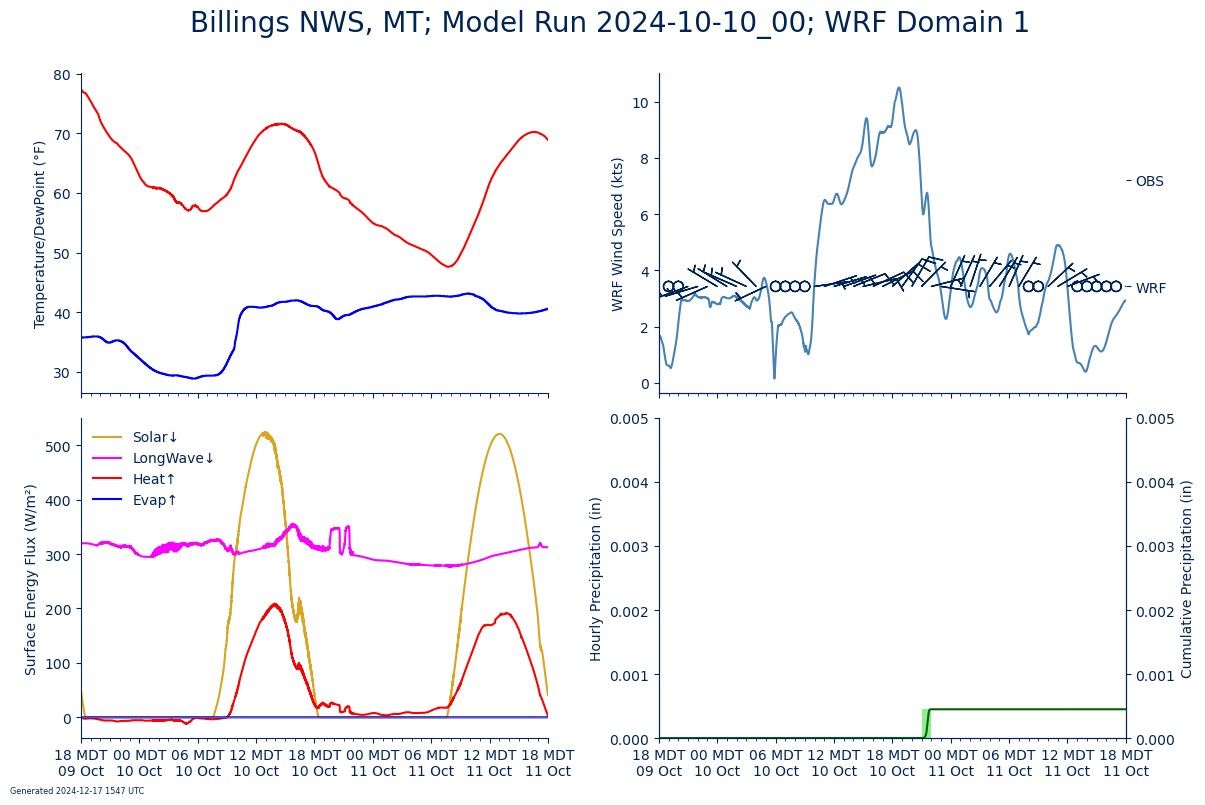

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KDEN.nc
distance between tslist and    wrf  3.2979370061244833
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


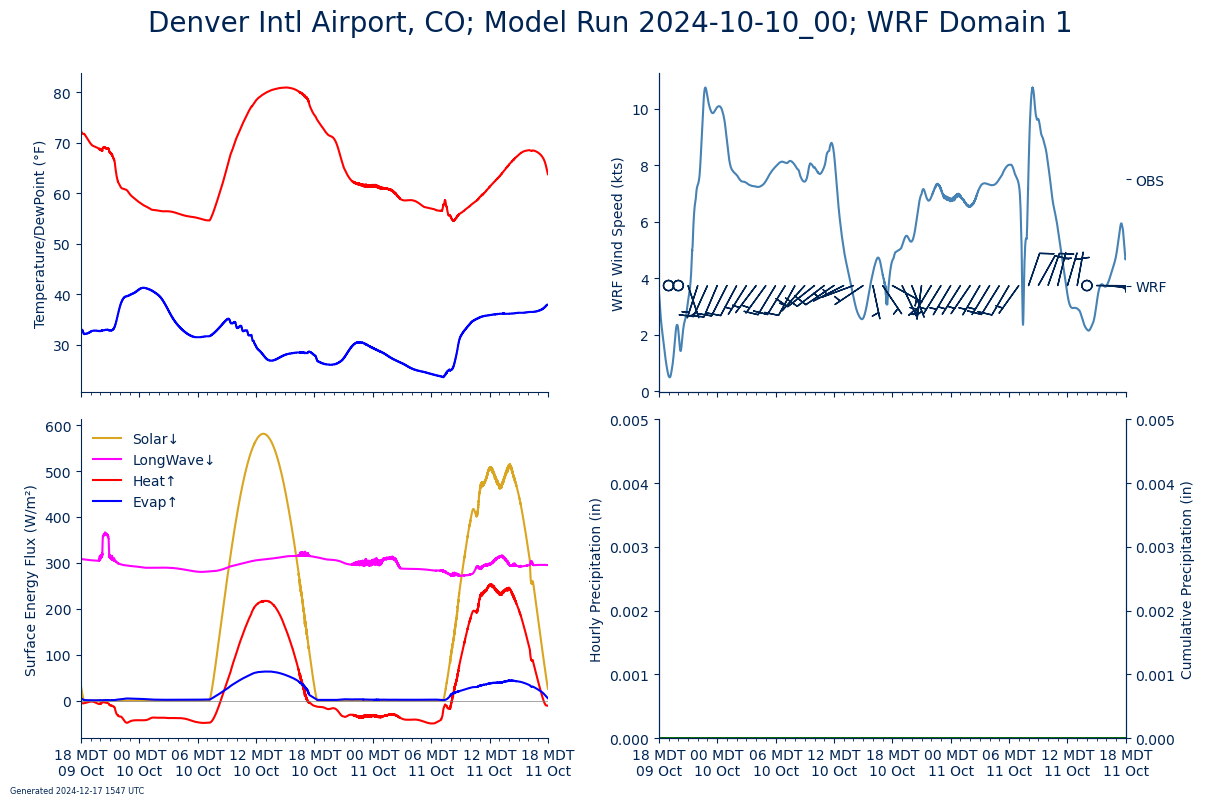

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KBOU.nc
distance between tslist and    wrf  1.533426337934672
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


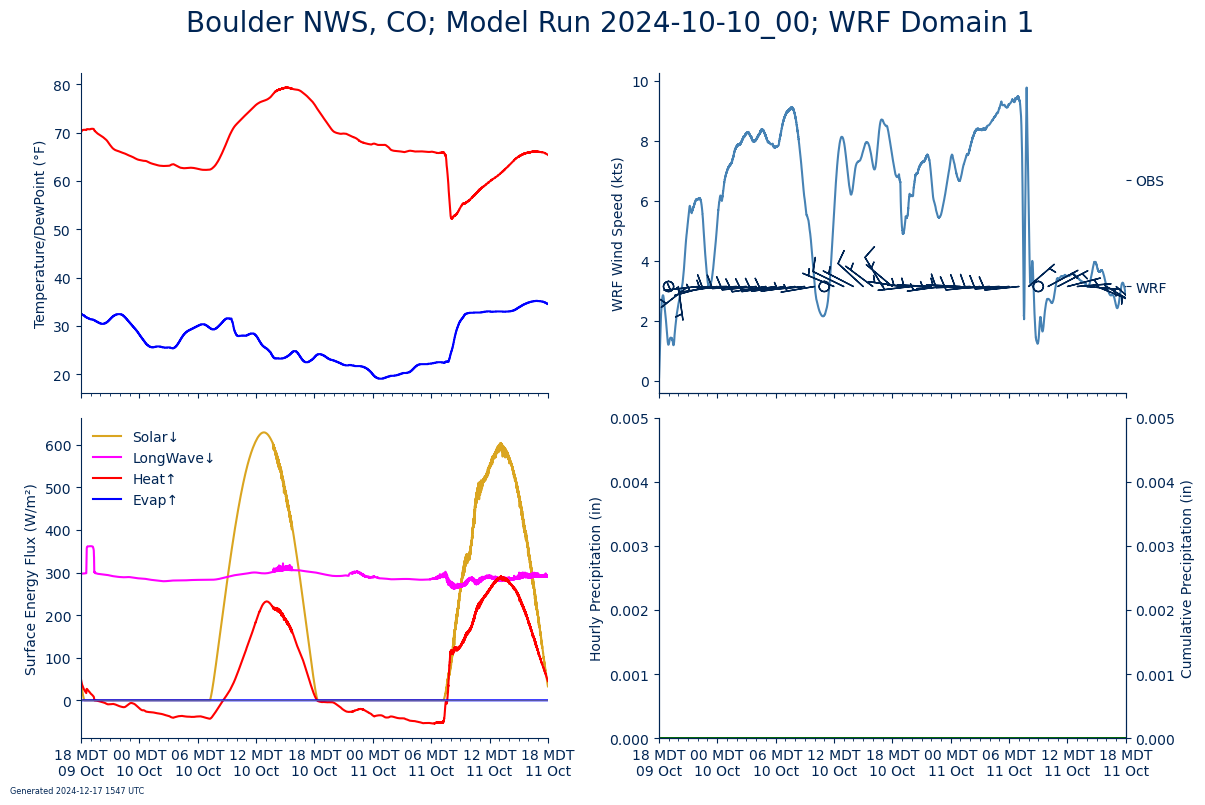

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KFSD.nc
distance between tslist and    wrf  2.4989034484103105
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


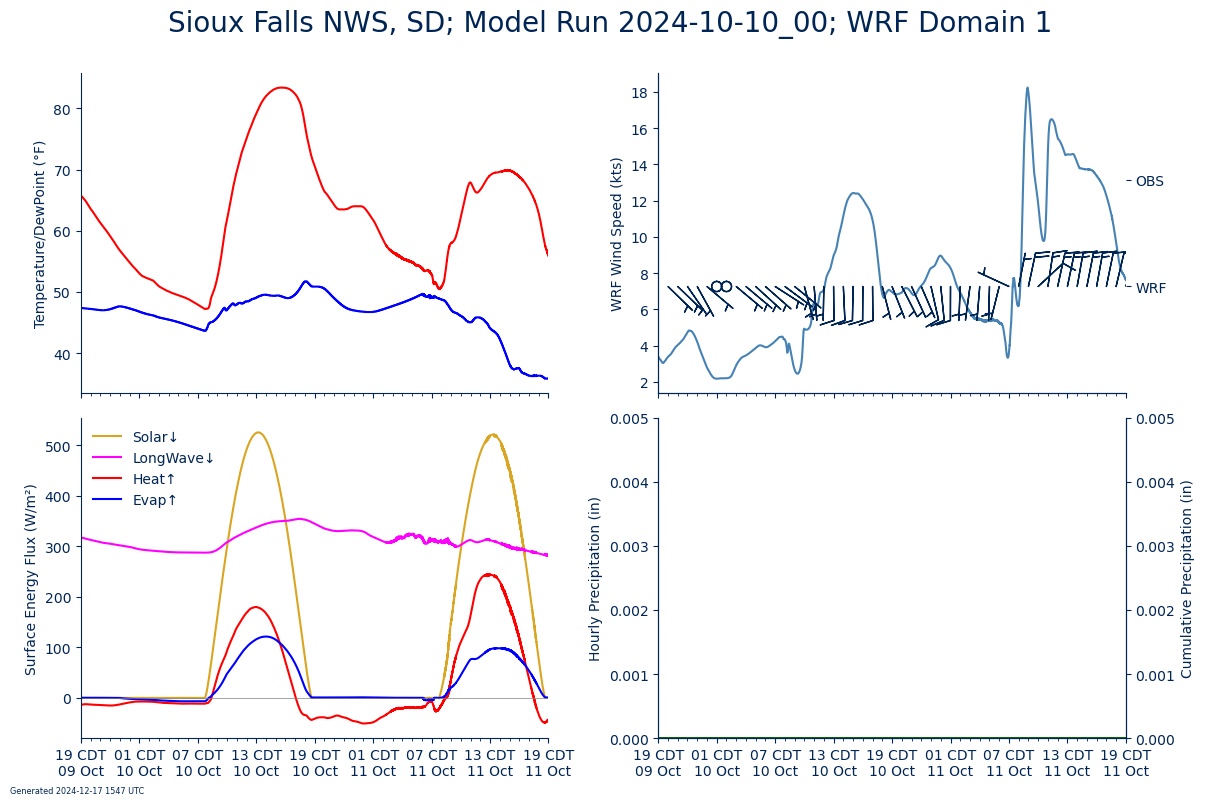

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KGGW.nc
distance between tslist and    wrf  1.122321896330335
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


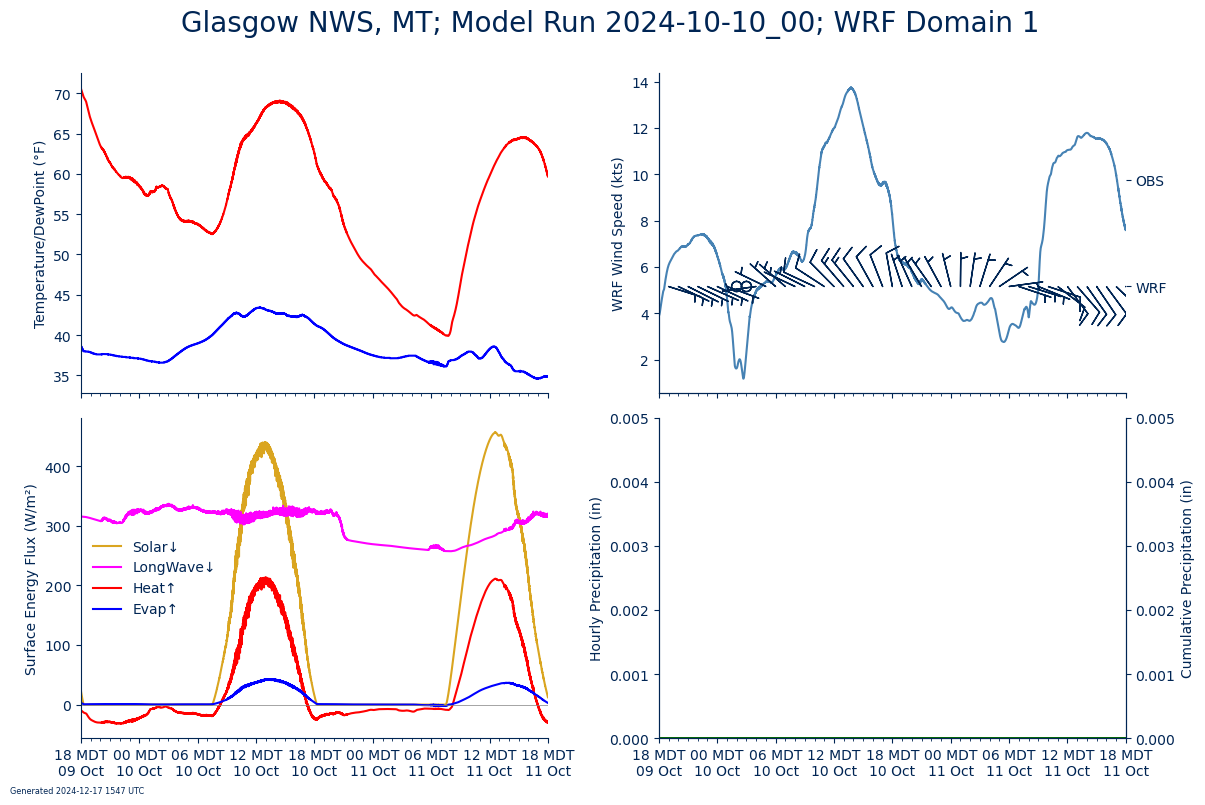

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KGLD.nc
distance between tslist and    wrf  0.6884891629561578
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


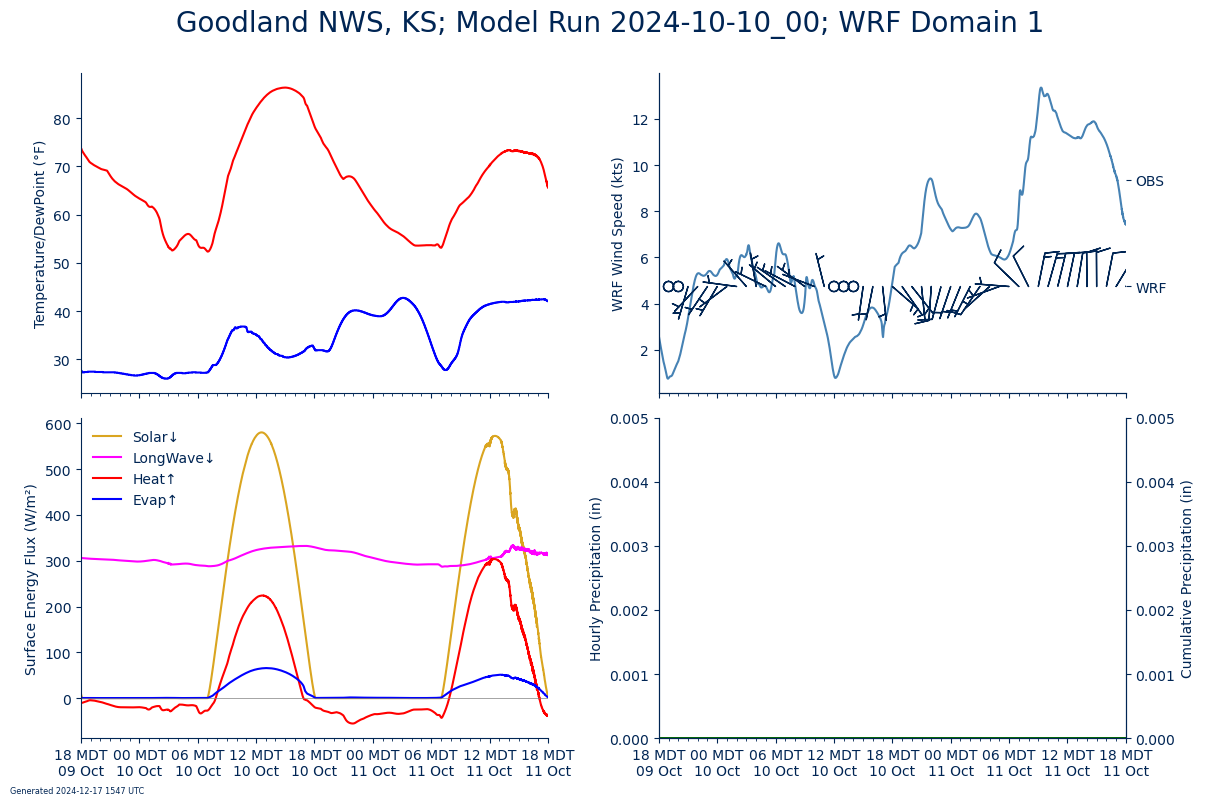

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KGID.nc
distance between tslist and    wrf  1.3973173254375242
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


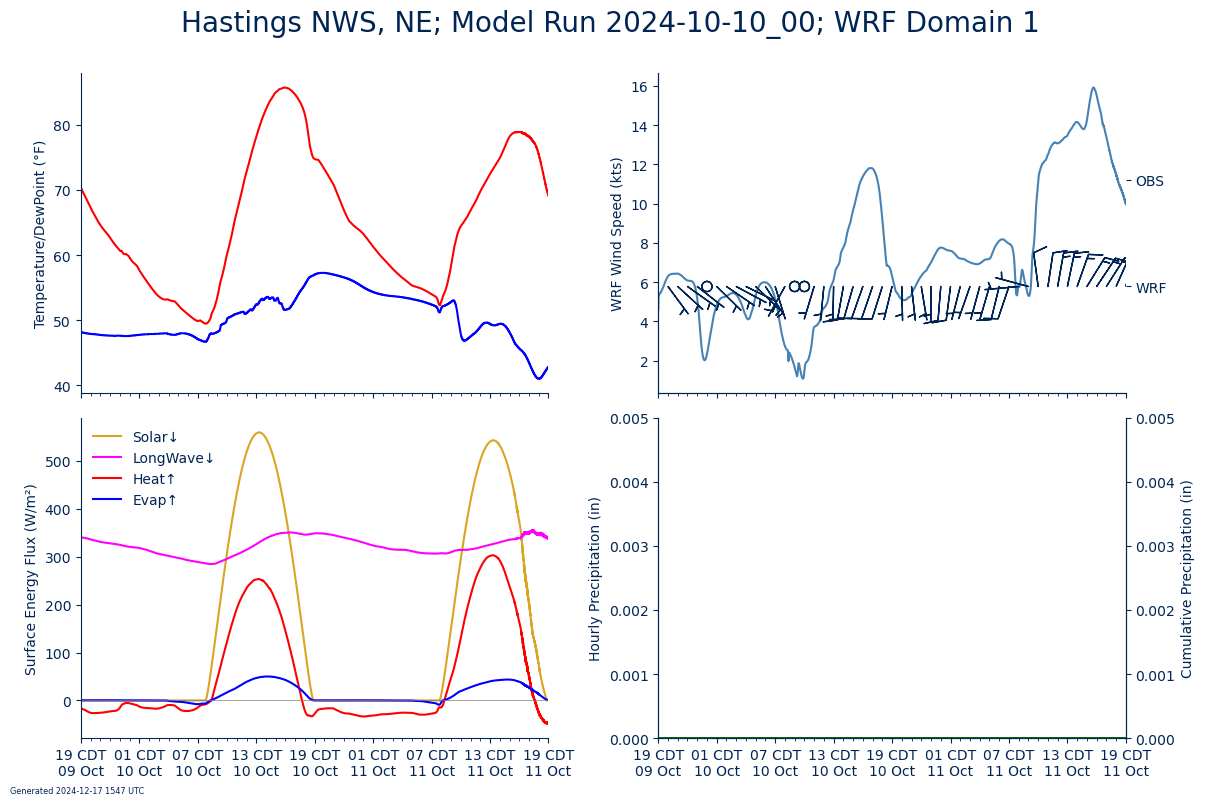

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_MUNS.nc
distance between tslist and    wrf  3.05818196715473
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


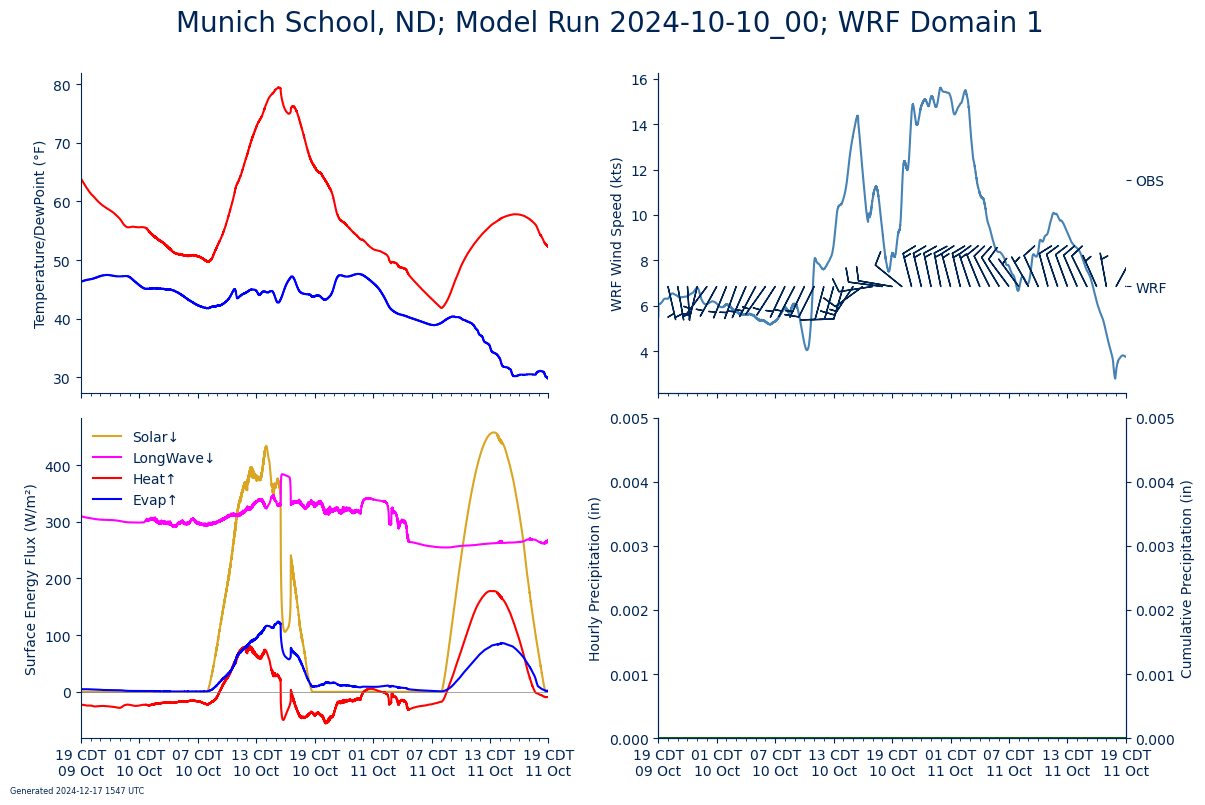

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KFGF.nc
distance between tslist and    wrf  2.947381892454605
Total precip:  7.282274803149607  in
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


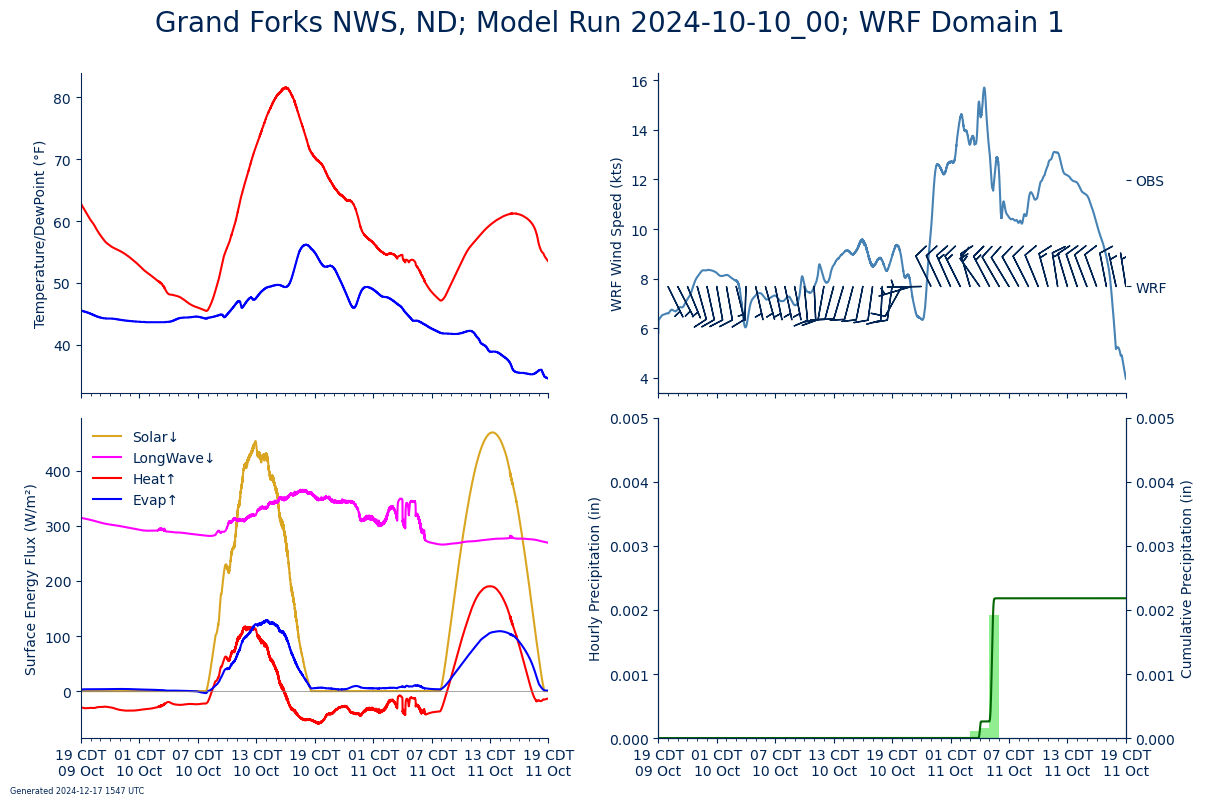

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KOAX.nc
distance between tslist and    wrf  4.057576339231067
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


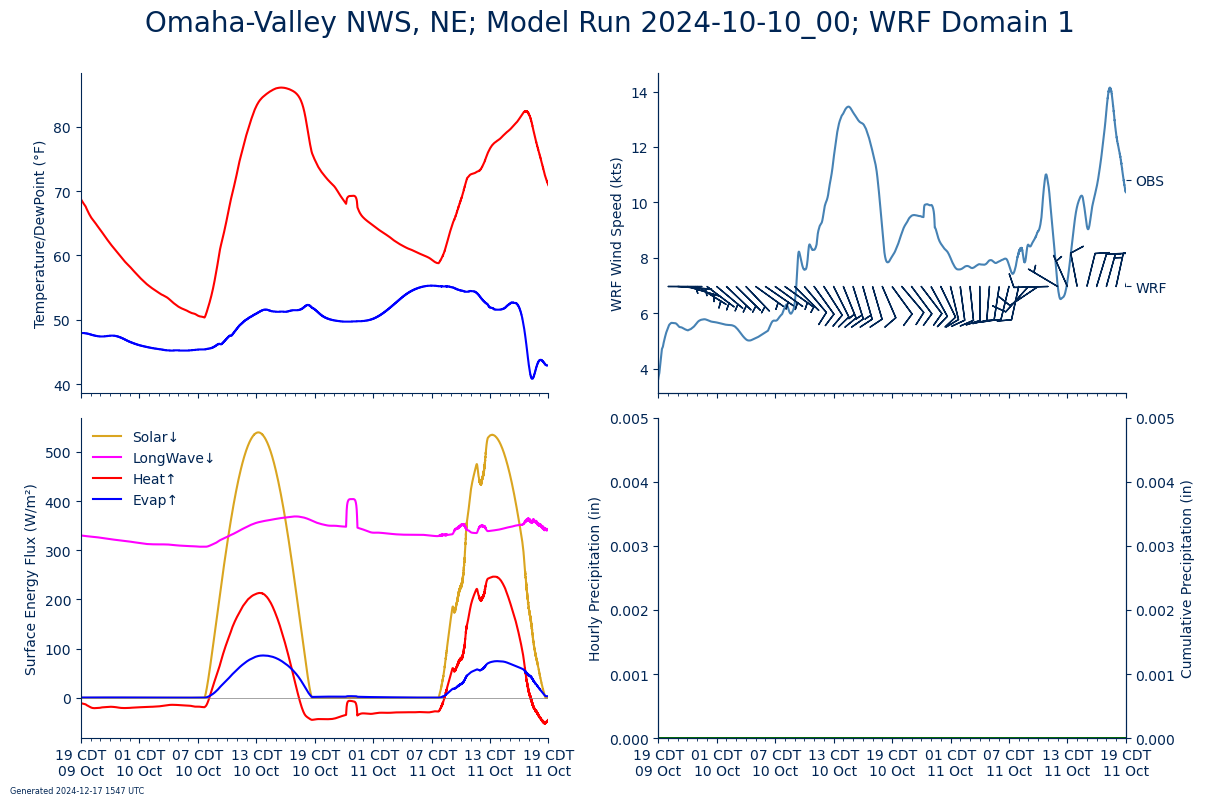

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KGJT.nc
distance between tslist and    wrf  4.370984518934833
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


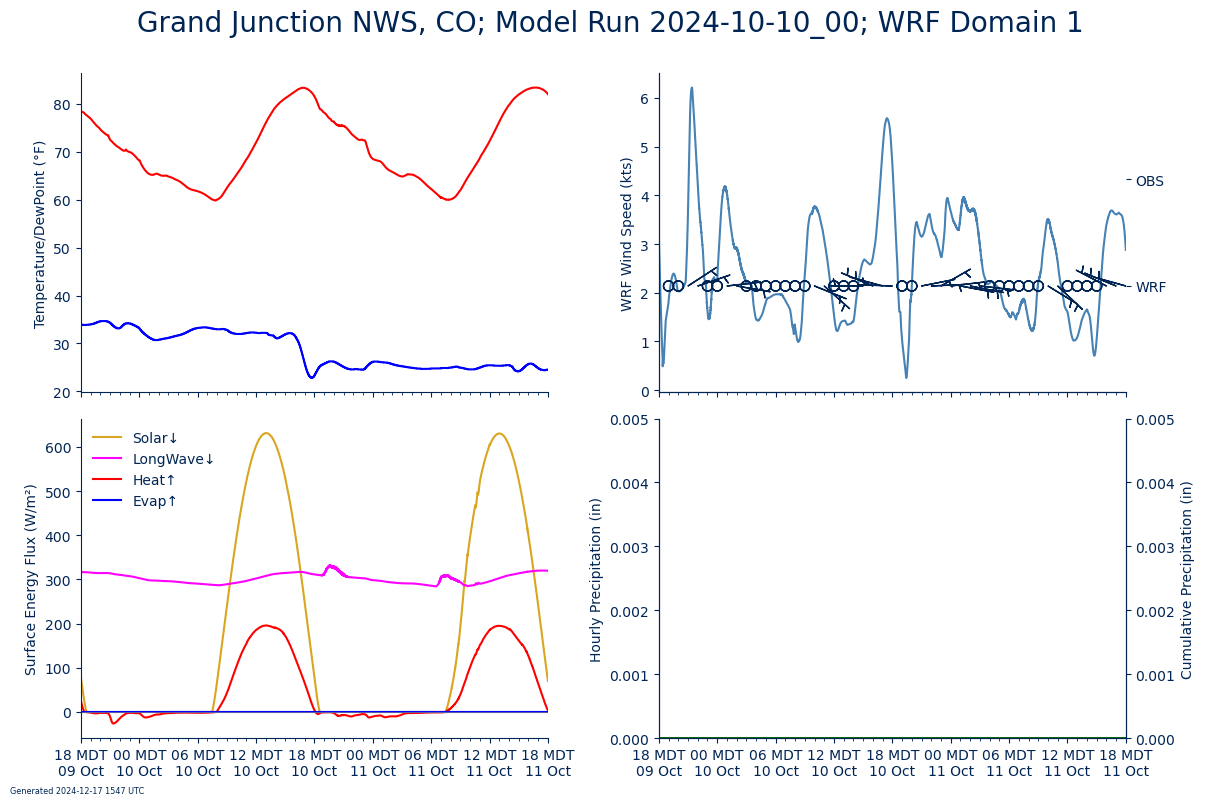

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2024-10-10_00_KTOP.nc
distance between tslist and    wrf  4.187029113699363
Total precip:  0.0  in
No Significant Rainfall
balls: air_temperature plot error
balls: dew_point_temperature plot error
balls: wind plotting error


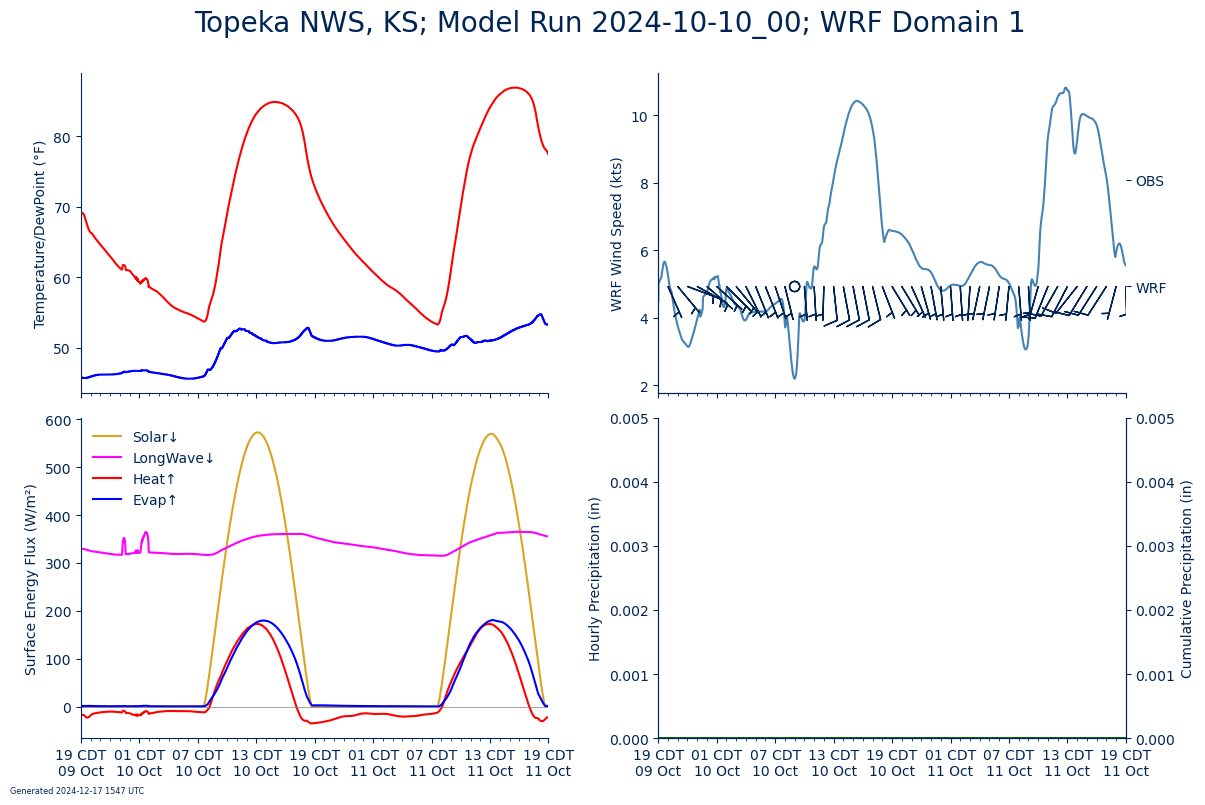

In [16]:
####################################################
####################################################
####################################################
#
# Rotate through Available Files
#

file_time = model_start_datetime.strftime('%Y-%m-%d_%H')

TS_DIR    = WRF_ARCHIVE  + "./current_complete_run/STATION_TIME_SERIES/"

#
# Creating Graphics Directory
#

graphics_directory = WRF_IMAGES + "./current_complete_run/STATION_TIME_SERIES/"

print("Creating " + graphics_directory)

os.system("mkdir -pv " + graphics_directory )

#
# Start File Rotation
#


for station_row in range(len(available_time_series_list)):

    ###################################################################
    #
    # Pull Station Data 
    #



    station_id     = available_time_series_list.iloc[station_row]["Station ID"]
    grid_domain    = available_time_series_list.iloc[station_row]["Domain"]
    station_name   = available_time_series_list.iloc[station_row]["Station Name"]
    station_lat    = available_time_series_list.iloc[station_row]["Latitude"]
    station_lon    = available_time_series_list.iloc[station_row]["Longitude"]


    #    
    ###################################################################

    ###################################################################
    #
    # Pull WRF Time Series
    #
    
    netcdf_file_name = TS_DIR + "./wrfout_d"+str(grid_domain).zfill(2)+"_"+file_time+"_"+station_id+".nc"
    
    wrf_timeseries = xr.open_dataset(netcdf_file_name, 
                                     engine='netcdf4')
    
    print(netcdf_file_name)

    #
    ###################################################################

    ###################################################################
    #
    # Select Metars for Closest Station
    #

  

    ###################################################################
    #
    # Get METARS for Station 
    #
    


    #
    # Get Nearest Station to Requested Station Point
    #
    

               
    

    
    


    sta_to_wrf_distance   = hs.haversine((station_lat,
                                          station_lon),
                                         (wrf_timeseries["wrf_grid_latitude" ].values[0],
                                          wrf_timeseries["wrf_grid_longitude"].values[0]))    
    
    print("distance between tslist and    wrf ",sta_to_wrf_distance)

    
    
    #    
    ###################################################################    

        







    #
    ###################################################################    
    

    ###################################################################
    ###################################################################
    #
    # Create Meteogram
    #

    ###################################################################
    #
    # Time Axes
    #
                                         
    tf     = tzf.TimezoneFinder()
    tz     = tf.certain_timezone_at(lng=station_lon, lat=station_lat)
    
    tzabbr = pytz.timezone(tz)#.localize(model_start_datetime)

    wrf_times  = pd.to_datetime(wrf_timeseries["time"]).tz_localize(tz="UTC").tz_convert(tz=tz)
    



    wrf_time_seconds  =  wrf_times.minute*60+wrf_times.second 
    on_the_hour       = np.where(wrf_time_seconds ==0)
    wrf_time_hrly     = wrf_times[on_the_hour]
    wrf_time_hrly_bar = wrf_times[on_the_hour]-datetime.timedelta(minutes=30)

    #
    ###################################################################


    ###################################################################
    #
    # Precip Prep
    #

    wrf_cum_prec      = wrf_timeseries["stratiform_precipitation_amount"].values + wrf_timeseries["convective_precipitation_amount"].values
    print("Total precip: ",np.sum(wrf_cum_prec)/25.4, " in")
    if (np.sum(wrf_cum_prec)/25.4 < 0.005):
        print("No Significant Rainfall")
        wrf_cum_prec[:] = 0.000
    
    wrf_cum_hrly_prec = wrf_cum_prec[on_the_hour]
    wrf_hrly_prec     = wrf_cum_hrly_prec.copy()

    wrf_hrly_prec[1:] = wrf_cum_hrly_prec[1:] - wrf_cum_hrly_prec[0:-1]
    
    wrf_hrly_prec     = wrf_hrly_prec     / 25.4
    wrf_cum_hrly_prec = wrf_cum_hrly_prec / 25.4
    wrf_cum_prec      = wrf_cum_prec      / 25.4

    #
    ###################################################################

    ###################################################################
    #
    # Wind Barb Prep
    #

    u_wrf = (wrf_timeseries["eastward_wind_10m"]*units("m")/units("s")).pint.to("knots")[on_the_hour]
    v_wrf = (wrf_timeseries["northward_wind_10m"]*units("m")/units("s")).pint.to("knots")[on_the_hour]

    spd_wrf = np.sqrt(wrf_timeseries[ "eastward_wind_10m"]**2 + 
                      wrf_timeseries["northward_wind_10m"]**2 )
    
    
    spd_wrf = (spd_wrf *units("m")/units("s")).pint.to("knots")                 

    #
    ###################################################################

    ###################################################################
    #
    # Plot Meteogram
    #

    fig, ax = plt.subplots(figsize = (12, 8),
                           nrows   =  2, 
                           ncols   =  2,
                           sharex  =  True)

    date_form = mdates.DateFormatter("%H %Z\n%d %b", tz=pytz.timezone(tz))
    xmajor = mdates.HourLocator(interval = 6)
    xminor = mdates.HourLocator(interval = 1)
    
    
    

    #
    # Temperature and Humidity
    #
    
    ax[0,0].plot(wrf_times,
             (wrf_timeseries["air_temperature_2m"]*units("K")).pint.to("degF"),
              color = "red")
    ax[0,0].plot(wrf_times,
             (wrf_timeseries["dew_point_temperature_2m"]*units("K")).pint.to("degF"),
              color = "blue")
    ax[0,0].set_ylabel("Temperature/DewPoint (°F)")


    try:
        ax[0,0].plot(ncss_times,
                 (metar_data["air_temperature"].to_numpy()*units("degC")).to("degF"),
                 marker = "o",
                 color="magenta",
                linestyle = "None")
    except:
        print("balls: air_temperature plot error")

    try:
        ax[0,0].plot(ncss_times,
                 (metar_data["dew_point_temperature"].to_numpy()*units("degC")).to("degF"),
                 marker = "o",
                 color="cyan",
                linestyle = "None")
    except:
        print("balls: dew_point_temperature plot error")


    #ax[0,1].set_title("Sta-to-WRF dist: " + str(round(metar_to_wrf_distance,1)) +" km")
    #ax[0,0].set_title("Nearest Sta: "     + weather_station_name +" ("+x.iloc[0]['station_id'] +")")
        


    #
    # Total Atmos Column Water + Wind Speed
    #
    
    ax[0,1].plot(wrf_times,
            spd_wrf,
              color = "steelblue")
    ax[0,1].set_ylabel("WRF Wind Speed (kts)")
 

    ax01 = ax[0,1].twinx()
    
    ax01.set_ylim(0,1)
    ax01.set_yticks([1/3.,2/3.])
    ax01.set_yticklabels(["WRF","OBS"])

    
    ax01.barbs( wrf_time_hrly, 1/3.,  u_wrf, v_wrf, color=Mines_Blue )


    

    try:
        ax01.barbs( ncss_times,    
                   2/3.,  
                   u_obs.astype('float64'),                  
                   v_obs.astype('float64'), 
                   color      = "blue")
    except:
        print("balls: wind plotting error")

   
    
    #
    # Surface Energy Budget
    #

    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_net_downward_shortwave_flux"],
                 color = "goldenrod")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_net_downward_longwave_flux"],
                 color = "magenta")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_upward_sensible_heat_flux"],
                 color = "red")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_upward_latent_heat_flux"],
                 color = "blue")
    ax[1,0].legend(["Solar↓","LongWave↓","Heat↑","Evap↑"],frameon=False)
    ax[1,0].set_ylabel("Surface Energy Flux (W/m²)")

    ax[1,0].axhline(y=0,color="grey", linewidth=0.5)
 
    #
    # Precipitation
    #

    ax[1,1].bar(wrf_time_hrly_bar,
                wrf_hrly_prec,
                linewidth=0,
                width=1/24, 
                color="lightgreen",
                edgecolor=None)
    ax11 = ax[1,1].twinx()
    ax11.plot(wrf_times,
              wrf_cum_prec, 
              color="darkgreen")
    ax11.set_ylabel("Cumulative Precipitation (in)")
    ax[1,1].set_ylabel("Hourly Precipitation (in)")
    ax[1,1].set_ylim(0., np.max([np.max(wrf_hrly_prec), 0.005]))
    ax11.set_ylim(   0., np.max([np.max( wrf_cum_prec), 0.005]))
    fig.suptitle(station_name+"; Model Run "+file_time+"; WRF Domain "+str(grid_domain),
                 fontsize=20)


    ax[1,0].set_xlim(model_start_datetime, model_end_datetime)
    ax[1,0].xaxis.set_major_formatter(date_form)
    ax[1,0].xaxis.set_major_locator(xmajor)
    ax[1,0].xaxis.set_minor_locator(xminor)
    ax[1,0].xaxis_date()

    ax[1,1].set_xlim(model_start_datetime, model_end_datetime)
    ax[1,1].xaxis.set_major_formatter(date_form)
    ax[1,1].xaxis.set_major_locator(xmajor)
    ax[1,1].xaxis.set_minor_locator(xminor)
    ax[1,1].xaxis_date()

    ax[0,0].set_xlim(model_start_datetime, model_end_datetime)
    ax[0,0].xaxis.set_major_formatter(date_form)
    ax[0,0].xaxis.set_major_locator(xmajor)
    ax[0,0].xaxis.set_minor_locator(xminor)
    ax[0,0].xaxis_date()

    ax[0,1].set_xlim(model_start_datetime, model_end_datetime)
    ax[0,1].xaxis.set_major_formatter(date_form)
    ax[0,1].xaxis.set_major_locator(xmajor)
    ax[0,1].xaxis.set_minor_locator(xminor)
    ax[0,1].xaxis_date()

    ax[0,0].spines["top"].set_visible(False)
    ax[1,0].spines["top"].set_visible(False)
    ax[0,1].spines["top"].set_visible(False)
    ax[1,1].spines["top"].set_visible(False)
    ax11.spines[   "top"].set_visible(False)
    ax01.spines[   "top"].set_visible(False)

    ax[0,0].spines["right"].set_visible(False)
    ax[1,0].spines["right"].set_visible(False)
    ax[0,1].spines["right"].set_visible(False)
    ax01.spines[   "right"].set_visible(False)

    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

    product_label = "Generated "+current_datetime.strftime('%Y-%m-%d %H%M %Z')
    fig.text(0,0,product_label, fontsize="xx-small")


    #plt.show()
    if (platform.system() != "Darwin"):
        fig.savefig(graphics_directory + "./wrfout_dxx_"+file_time+"_"+station_id+".png",
                        facecolor   = 'white', 
                        transparent =   False)
    else:
        plt.show()

    plt.close('all')


    #
    ###################################################################

    #
    ###################################################################
    ###################################################################
    
    print(" ")



## Depart 

In [ ]:
####################################################
####################################################
####################################################
#
# End of Script
#

print("Ploting Meteogram Script complete.")

#
####################################################
####################################################
####################################################

'Generated 2024-12-17 1547 UTC'